# Abstract Network
This notebook aims to evaluate an entire abstracted network. 
At the end, some pruning trial will be performed.

In [3]:


%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')
sys.path.append('../util')
import torch
import torch.nn as nn


from abstractModule import AbstractReLU as AR
from abstractModule import AbstractMaxpool2D as AM
from abstractWeight import AbstractWeight as AW
from abstractNN import AbstractNN as NN
from custom_train import CustomTrainer as T
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import random_split
from torch import optim
import os

import numpy as np
device = torch.device('cpu')

In [4]:

path ='dataset'

os.makedirs(path, exist_ok=True)

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean =[0.5], std =[0.2]),
        #transforms.Resize((56,56))
    ])



dataset_train = datasets.FashionMNIST(root = path,transform = transform, download = True, train = True)
dataset_test =datasets.FashionMNIST( root =path,transform=transform ,download = True, train = False)
val =0.2
len_data_train = len(dataset_train)
train_size =int((1-val)*len_data_train)

val_size = int(val*len_data_train)

train_dataset, val_dataset = random_split(dataset_train, [train_size,val_size])


# The network
We are still working on our simple CNN network for benchmark.
The forward abstract method is implemented with abstractNN method. 
abstractNN.abstract_linear takes in input a nn.Sequential(nn.Flatten, nn.Linear), an abstract tensor, and two tupple of index/values for abstraction of weight and bias. 


In [5]:


class AbstractNN(nn.Module):
    
    def __init__(self,num_depth=1,device=torch.device("cpu")):

        super(AbstractNN,self).__init__()
       
      
        self.num_depth = num_depth
        self.device = device
        self.conv1=nn.Conv2d(self.num_depth,16,3,device=self.device)
        self.conv2=nn.Conv2d(16,32,3,device=self.device)
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
  

       

        self.fc1=nn.Sequential(nn.Flatten(),nn.Linear(4608,64,device=self.device))
        self.fc2=nn.Sequential(nn.Flatten(),nn.Linear(64,10,device=self.device))
        self.softMax =nn.Softmax()
    def forward(self,x):
        x=self.conv1(x)
        x=torch.relu(x)
        x=self.conv2(x)
        x=torch.relu(x)
     
        x=self.maxpool(x)
     
    
        x=self.fc1(x)
        x=torch.relu(x)
        x=self.fc2(x)
        x=torch.relu(x)
        x= self.softMax(x)
        return x
    
    def abstract_forward(self,x,
                         conv1_eps_weight,
                         conv1_eps_bias,
                         conv2_eps_weight,
                         conv2_eps_bias,
                         fc1_eps_weight,
                         fc1_eps_bias, 
                         fc2_eps_weight,
                         fc2_eps_bias,
                         add_symbol=False,
                         device=torch.device("cpu")):
        self.device=device
        AR.max_symbol = np.inf
        AM.max_symbol = np.inf
        AR.recycling = 1
        AM.recycling =1 
        
        x_true = x
        x_true = x_true[0].unsqueeze(0)
      
        x,x_min,x_max,x_true = NN.abstract_conv2D(self.conv1,x,x_true,conv1_eps_weight , conv1_eps_bias,device=self.device)
     
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
   
        symb_1 = len(x)
       
        x,x_min,x_max,x_true = NN.abstract_conv2D(self.conv2,x,x_true,conv2_eps_weight,conv2_eps_bias,device=self.device)
       
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
       
      
        x,x_min,x_max ,x_true = AM.abstract_maxpool2D(self.maxpool,x,x_true,add_symbol=add_symbol,device=self.device)
    
      
        symb_conv2 =len(x)
        x,x_min,x_max,x_true = NN.abstract_linear(self.fc1,x,x_true,fc1_eps_weight,fc1_eps_bias,device=self.device)
     
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
  
  
        symb_fc1 = len(x)
        x,x_min,x_max,x_true = NN.abstract_linear(self.fc2,x,x_true,fc2_eps_weight,fc2_eps_bias,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        
        
        return x,x_min,x_max,x_true,symb_1,symb_conv2, symb_fc1
        

Label:5


torch.Size([2, 1, 28, 28])

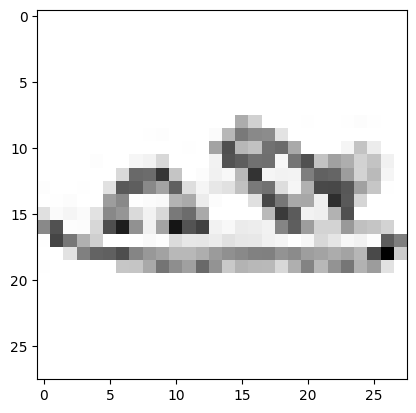

In [6]:

import matplotlib.pyplot as plt
import numpy as np

img, label = dataset_train[1310]
plt.imshow(1-img[0],cmap='gray')
print(f"Label:{label}")
img.shape
from abstract import abstractTensor as AT

x=AT(img,alpha =torch.tensor([]))
x=x.abstract_tensor()
x.shape

In [7]:
model = AbstractNN()

Here you can read an example how to generate tupples for weight and bias abstraction
Some methods need to be implement

In [8]:
scale = 0.0001
conv1_eps_weight = torch.tensor([])
conv1_eps_weight.indices = torch.arange(0,len(model.conv1.weight.data.flatten()),1)
conv1_eps_weight.values = scale*(1)*torch.ones_like(conv1_eps_weight.indices)
conv1_eps_bias = torch.tensor([])
conv1_eps_bias.indices = torch.arange(0,len(model.conv1.bias.data.flatten()),1)
conv1_eps_bias.values = scale*(1)*torch.ones_like(conv1_eps_bias.indices)


conv2_eps_weight = torch.tensor([])
conv2_eps_weight.indices = torch.arange(0,len(model.conv2.weight.data.flatten()),1)
conv2_eps_weight.values = scale*(1)*torch.ones_like(conv2_eps_weight.indices)
conv2_eps_bias = torch.tensor([])
conv2_eps_bias.indices = torch.arange(0,len(model.conv2.bias.data.flatten()),1)
conv2_eps_bias.values = scale*(1)*torch.ones_like(conv2_eps_bias.indices)

fc1_eps_weight = torch.tensor([])
fc1_eps_weight.indices = torch.arange(0,len(model.fc1[1].weight.data.flatten()),1)
fc1_eps_weight.values = scale*(1)*torch.ones_like(fc1_eps_weight.indices)
fc1_eps_bias = torch.tensor([])
fc1_eps_bias.indices = torch.arange(0,len(model.fc1[1].bias.data.flatten()),1)
fc1_eps_bias.values = scale*(1)*torch.ones_like(fc1_eps_bias.indices)


fc2_eps_weight = torch.tensor([])
fc2_eps_weight.indices = torch.arange(0,len(model.fc2[1].weight.data.flatten()),1)
fc2_eps_weight.values = scale*(1)*torch.ones_like(fc2_eps_weight.indices)
fc2_eps_bias = torch.tensor([])
fc2_eps_bias.indices = torch.arange(0,len(model.fc2[1].bias.data.flatten()),1)
fc2_eps_bias.values = scale*(1)*torch.ones_like(fc2_eps_bias.indices)

In [9]:
model = AbstractNN()

In [122]:
with torch.no_grad():

   result,x_min,x_max,x_true,_,_,_=model_assesment.abstract_forward(x,
                                                    conv1_eps_bias=conv1_eps_bias,
                                                    conv1_eps_weight=conv1_eps_weight,
                                                    conv2_eps_weight = conv2_eps_weight,
                                                    conv2_eps_bias = conv2_eps_bias,
                                                    fc1_eps_weight =fc1_eps_weight,
                                                    fc1_eps_bias = fc1_eps_bias, 
                                                    fc2_eps_weight = fc2_eps_weight,
                                                    fc2_eps_bias = fc2_eps_bias,

                                                    
                                                    add_symbol=True)

print(f"y_min       =  {x_min}")
print(f"y_max       =  {x_max}")
print(f"center Ztp  =  {result[0]}")
print(f"y_true      =  {x_true[:]}")
print(f"y_max-x_min =  {x_max-x_min}")
print(f"Trash symbol=  {result[-1]}")

y_min       =  tensor([-12.0888, -11.8326, -10.4294, -11.4788, -11.6199, -13.6437, -11.8750,
        -11.1952, -11.3097, -11.6626])
y_max       =  tensor([24.2387, 23.8627, 20.0251, 24.8169, 22.1594, 29.2049, 23.1445, 25.0692,
        19.7323, 21.2065])
center Ztp  =  tensor([6.0750, 6.0151, 4.7979, 6.6690, 5.2697, 7.7806, 5.6348, 6.9370, 4.2113,
        4.7719])
y_true      =  tensor([[0.0000, 0.7533, 0.0000, 0.6993, 0.0000, 1.6569, 0.0000, 0.9735, 0.0000,
         0.0000]])
y_max-x_min =  tensor([36.3275, 35.6953, 30.4545, 36.2957, 33.7793, 42.8486, 35.0195, 36.2645,
        31.0420, 32.8691])
Trash symbol=  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [7]:
import matplotlib.pyplot as plt
import numpy as np
def plot_dominance(result,x_min,x_max,x_true):
       y_min       =  np.array(x_min)
       y_max       =  np.array(x_max)
       center_Ztp  =  np.expand_dims(np.array(result[0]),axis =1)
       y_true      =  np.expand_dims(np.array(x_true[:])[0],axis =1)



       




       x_scale = np.arange(len(y_min))
       D =np.stack((y_min,y_max),axis=1)

   
       # plot:

       fig,ax = plt.subplots(1, 1, figsize=(8,4), tight_layout=True)
       ax.eventplot(D, orientation="vertical", linewidth=1,color='blue',linelengths=0.3)
       ax.eventplot(y_true, orientation="vertical", linewidth=0.50,color='green',linelengths=0.4)
       ax.eventplot(center_Ztp, orientation="vertical", linewidth=1,color='red',linelengths=0.5)

       ax.set(xlim=(-0.5, 10),xticks=x_scale,xticklabels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag,","Ankle boot"],
              ylim=(np.min(D)-1, np.max(D)+1))
       plt.ylabel("Value of the abstract domain")
       plt.title("Dominance interval for the 10 classes of Fashion MNIST .\n Abstract domain based on 100_000 lower weights of the first layer of the first fully connected layer of the model")
       plt.legend()
       plt.show()


In [12]:
model = AbstractNN()

In [13]:
#model.load_state_dict(torch.load('dataset/FMNIST.pth'))
from custom_train import CustomTrainer as CT
eval =CT(model, device = device)
eval.evaluate_model(dataset_test)

EPOCH ACCURACY = 11.52 %


tensor(11.5200)

In [14]:
model = AbstractNN()
model.load_state_dict(torch.load('240523_abstractLearn_47.pth'))
from custom_train import CustomTrainer as CT
eval =CT(model, device = device)
eval.evaluate_model(dataset_test)

EPOCH ACCURACY = 47.16 %


tensor(47.1600)

In [91]:

torch.save(best_model_wts, f'model_first_step.pth')

In [15]:
model = AbstractNN()
torch.save(model.state_dict(), f'modelseeds.pth')
from custom_train import CustomTrainer as CT
eval =CT(model, device = device)
eval.evaluate_model(dataset_test)

EPOCH ACCURACY = 15.54 %


tensor(15.5400)

In [29]:
model.load_state_dict(torch.load('modelseeds.pth'))

<All keys matched successfully>

In [255]:

model = AbstractNN()
model.load_state_dict(torch.load('model_first_step3627.pth'))
#model.load_state_dict(torch.load('modelseeds.pth'))

<All keys matched successfully>

In [ ]:


num_epochs =10
learning_rate=0.01
batch_size = 128

optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.99))
scheduler =  optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.98)
criterion = nn.CrossEntropyLoss()
TD= T(model=model,
            device=device
                            )
model = TD.train_model(train_dataset,val_dataset,
                        criterion=criterion,  
                        batch_size= batch_size,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        num_epochs=num_epochs,
                        learning_rate=learning_rate,
                        resname='trainfromabstract',verbose=False)

In [17]:
for param in model.parameters():
    param.data = torch.zeros_like(param.data)

torch.sum(model.conv1.weight.data)

tensor(0.)

  0%|          | 0/120 [00:00<?, ?it/s]

/home/guillaume/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


EPOCH ACCURACY = 10.19 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


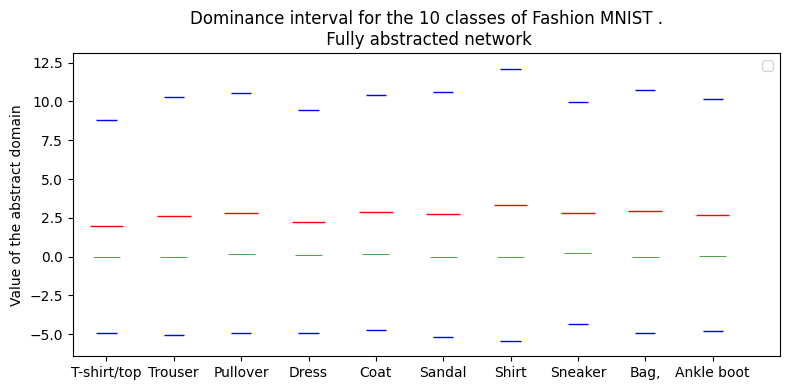

  4%|▍         | 5/120 [02:45<1:08:06, 35.54s/it]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


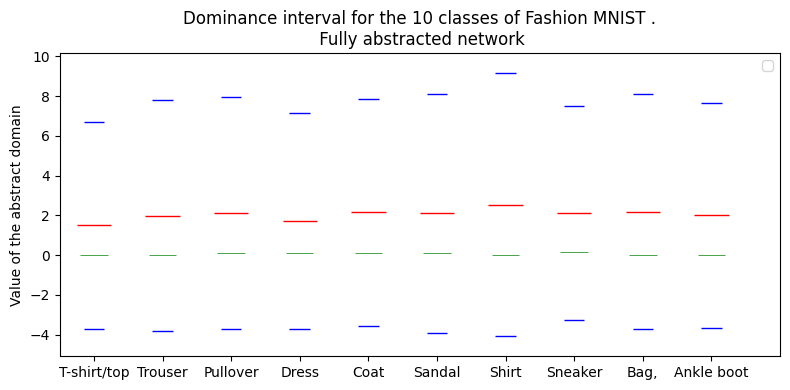

  8%|▊         | 9/120 [04:56<1:04:45, 35.01s/it]

Update parameter after EPOCH 9
Update parameter after EPOCH 9


/home/guillaume/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


EPOCH ACCURACY = 10.24 %
Update parameter after EPOCH 9
Update parameter after EPOCH 9
EPOCH ACCURACY = 10.36 %
Update parameter after EPOCH 9
Update parameter after EPOCH 9
EPOCH ACCURACY = 10.45 %
Update parameter after EPOCH 9
Update parameter after EPOCH 9
EPOCH ACCURACY = 10.60 %
Update parameter after EPOCH 9
Update parameter after EPOCH 9
EPOCH ACCURACY = 10.76 %
Update parameter after EPOCH 9
Update parameter after EPOCH 9
EPOCH ACCURACY = 10.87 %
Update parameter after EPOCH 9
Update parameter after EPOCH 9
EPOCH ACCURACY = 11.09 %
Update parameter after EPOCH 9
Update parameter after EPOCH 9
EPOCH ACCURACY = 11.48 %
Update parameter after EPOCH 9
Update parameter after EPOCH 9
EPOCH ACCURACY = 11.98 %
Update parameter after EPOCH 9
Update parameter after EPOCH 9
EPOCH ACCURACY = 12.75 %
Update parameter after EPOCH 9
Update parameter after EPOCH 9
EPOCH ACCURACY = 13.58 %
Update parameter after EPOCH 9
Update parameter after EPOCH 9
EPOCH ACCURACY = 14.27 %
Update parameter a

  8%|▊         | 10/120 [07:32<2:12:39, 72.36s/it]

EPOCH ACCURACY = 24.73 %
new seed generated with accuracy  tensor(24.7300)
New exploration domain of scale 0.001.
EPOCH ACCURACY = 24.73 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


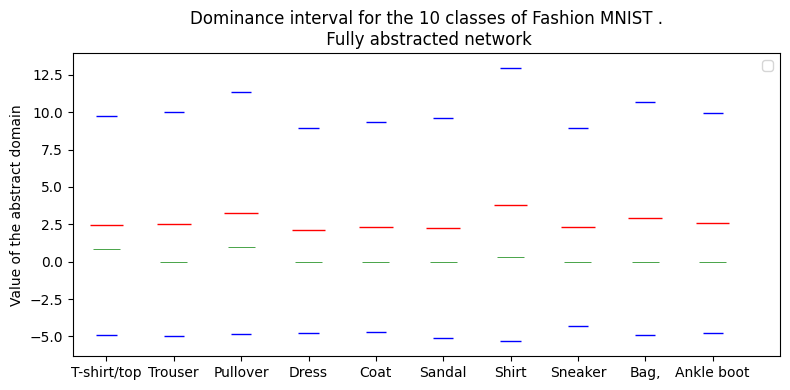

 11%|█         | 13/120 [08:44<1:12:45, 40.80s/it]

In [214]:
import matplotlib.pyplot as plt
import copy
import numpy as np
from tqdm import tqdm
from abstract import abstractTensor as AT
from common import make_indice_and_values_tupple,plot_dominance
abstract_network = True
random__image_select = False
model = AbstractNN()
#model.load_state_dict(torch.load('model_first_step3627.pth'))
#model.load_state_dict(torch.load('modelseeds.pth'))
"""
Xperience over sparse initialisation
for param in model.parameters():
    param.data = torch.zeros_like(param.data)
for param in model.parameters():
    shape = param.data.shape
    tensor = torch.zeros(shape)
    num_elements = tensor.numel()
    num_random_elements = int(0.5 * num_elements)
    random_indices = np.random.choice(num_elements, num_random_elements, replace=False)
    random_values = 1/10*torch.randn(num_random_elements)
    multi_dim_indices = np.unravel_index(random_indices, tensor.shape)
    tensor[multi_dim_indices] = random_values
    param.data =tensor
    """

xticklabels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag,","Ankle boot"]

img_list = []
img_relevance_list =[]
conv1_weight_relevance_list = []
conv1_bias_relevance_list = []
conv2_weight_relevance_list = []
conv2_bias_relevance_list = []

fc1_weight_relevance_list = []
fc1_bias_relevance_list = []
fc2_weight_relevance_list = []
fc2_bias_relevance_list  = []
result_list =[]
num_label_list = []
name_label_list = []
true_predict_list = []
k_plus = 1
best_model_wts = None
lr=2
best_acc = 0
best_epoch_indice = 0

scale_init = 0.001
noise = 0.15
scale = scale_init
       
for i in tqdm(range(120)):
    if i%10==0:
        eval =CT(model, device = device)
        eval.evaluate_model(dataset_test)
 
   
   
    if abstract_network : 
    
        conv1_eps_weight = torch.tensor([])
        conv1__weight_span = torch.max(model.conv1.weight.data.flatten())-torch.min(model.conv1.weight.data.flatten())
        conv1_eps_weight.indices = torch.arange(0,len(model.conv1.weight.data.flatten()),1)
        conv1_eps_weight.values = scale*torch.ones_like(conv1_eps_weight.indices)
        conv1_eps_bias = torch.tensor([])
        conv1__bias_span = torch.max(model.conv1.bias.data.flatten())-torch.min(model.conv1.bias.data.flatten())
        conv1_eps_bias.indices = torch.arange(0,len(model.conv1.bias.data.flatten()),1)
        conv1_eps_bias.values = scale*torch.ones_like(conv1_eps_bias.indices)


        conv2_eps_weight = torch.tensor([])
        conv2_eps_weight.indices = torch.arange(0,len(model.conv2.weight.data.flatten()),1)
        conv2_weight_span = torch.max(model.conv2.weight.data.flatten())-torch.min(model.conv2.weight.data.flatten())
        conv2_eps_weight.values = scale*torch.ones_like(conv2_eps_weight.indices)
        conv2_eps_bias = torch.tensor([])
        conv2_eps_bias.indices = torch.arange(0,len(model.conv2.bias.data.flatten()),1)
        conv2_bias_span = torch.max(model.conv2.bias.data.flatten())-torch.min(model.conv2.bias.data.flatten())
        conv2_eps_bias.values = scale*torch.ones_like(conv2_eps_bias.indices)

        fc1_eps_weight = torch.tensor([])
        fc1_weight_span = torch.max(model.fc1[1].weight.data.flatten())-torch.min(model.fc1[1].weight.data.flatten())
        fc1_eps_weight.indices = torch.arange(0,len(model.fc1[1].weight.data.flatten()),1)
        fc1_eps_weight.values = scale*torch.ones_like(fc1_eps_weight.indices)
        fc1_eps_bias = torch.tensor([])
        fc1_bias_span = torch.max(model.fc1[1].bias.data.flatten())-torch.min(model.fc1[1].bias.data.flatten())
        fc1_eps_bias.indices = torch.arange(0,len(model.fc1[1].bias.data.flatten()),1)
        fc1_eps_bias.values = scale*torch.ones_like(fc1_eps_bias.indices)


        fc2_eps_weight = torch.tensor([])
        fc2_weight_span = torch.max(model.fc2[1].weight.data.flatten())-torch.min(model.fc2[1].weight.data.flatten())
        fc2_eps_weight.indices = torch.arange(0,len(model.fc2[1].weight.data.flatten()),1)
        fc2_eps_weight.values = scale*fc2_weight_span*torch.ones_like(fc2_eps_weight.indices)
        fc2_eps_bias = torch.tensor([])
        fc2_bias_span = torch.max(model.fc2[1].bias.data.flatten())-torch.min(model.fc2[1].bias.data.flatten())
        fc2_eps_bias.indices = torch.arange(0,len(model.fc2[1].bias.data.flatten()),1)
        fc2_eps_bias.values = scale*torch.ones_like(fc2_eps_bias.indices)


    else :
        conv1_eps_weight = make_indice_and_values_tupple()
        conv1_eps_bias = make_indice_and_values_tupple()
       

        conv2_eps_weight = make_indice_and_values_tupple()
        conv2_eps_bias = make_indice_and_values_tupple()
        fc1_eps_bias = make_indice_and_values_tupple()
        fc1_eps_weight = make_indice_and_values_tupple()
        fc2_eps_weight = make_indice_and_values_tupple()
        fc2_eps_bias = make_indice_and_values_tupple()




    label = None

    if random__image_select:
        while label!= i%10: 
            index = np.random.randint(0,5000)
            
            img, label = dataset_train[index]
    else :
        index = 0
        while label!= i%10:
            img, label = dataset_train[index]
            index+=1

    name_label_list.append(xticklabels[label])
    num_label_list.append(label)
   
    img_list.append(img)
    
    x=AT(img,alpha =noise*torch.ones(28*28))
    x=x.abstract_tensor()


    
  
    with torch.no_grad():
      
        
        result,x_min,x_max,x_true,len_symb, len_symb_c2, len_symb_fc1=model.abstract_forward(x,
                                                                    conv1_eps_bias=conv1_eps_bias,
                                                                    conv1_eps_weight=conv1_eps_weight,
                                                                    conv2_eps_weight = conv2_eps_weight,
                                                                    conv2_eps_bias = conv2_eps_bias,

                                                                    fc1_eps_weight =fc1_eps_weight,
                                                                    fc1_eps_bias = fc1_eps_bias, 
                                                                    fc2_eps_weight = fc2_eps_weight,
                                                                    fc2_eps_bias = fc2_eps_bias,

                                                                    add_symbol=True)
        
    result_list.append([result,x_min,x_max,x_true,len_symb, len_symb_c2, len_symb_fc1])    
    true_predict_list.append(torch.argmax(x_true))
   
    if i%5==0:
        plot_dominance(result,x_min,x_max,x_true)



    concatenated_heatmap_tensors =[]
    for j in range(10):
        concat_part =result[1:785,j]
        concatenated_heatmap_tensors.append(concat_part)
    concatenated_heatmap_tensors = torch.stack(concatenated_heatmap_tensors)

    img_relevance_list.append(concatenated_heatmap_tensors)

  
    if abstract_network:

        conv1_weight_concatenated_tensors = []
        conv1_bias_concatenated_tensors =[]
        for j in range(10):
            concat_part = result[len(x)-1:len(x)+143, j].view(16, 1, 3, 3)
            conv1_weight_concatenated_tensors.append(concat_part)
        conv1_weight_concatenated_tensors =torch.stack(conv1_weight_concatenated_tensors)
        for j in range(10):
            concat_part= result[len(x)+143:len(x)+159, j]
            conv1_bias_concatenated_tensors .append(concat_part)
        conv1_bias_concatenated_tensors = torch.stack(conv1_bias_concatenated_tensors )

        conv2_weight_concatenated_tensors = []
        conv2_bias_concatenated_tensors =[]
        for j in range(10):
            concat_part = result[len_symb-1:len_symb+4607, j].view(32, 16, 3, 3)
            conv2_weight_concatenated_tensors.append(concat_part)
        conv2_weight_concatenated_tensors =torch.stack(conv2_weight_concatenated_tensors)
        for j in range(10):
            concat_part = result[len_symb+4607:len_symb+4639, j]
            conv2_bias_concatenated_tensors.append(concat_part)
        conv2_bias_concatenated_tensors = torch.stack(conv2_bias_concatenated_tensors)

        fc1_weight_concatenated_tensors = []
        fc1_bias_concatenated_tensors =[]
        for j in range(10):
            concat_part = result[len_symb_c2-1:len_symb_c2+294911, j].reshape(64,4608)
            fc1_weight_concatenated_tensors.append(concat_part)
        fc1_weight_concatenated_tensors =torch.stack(fc1_weight_concatenated_tensors)
        for j in range(10):
            concat_part = result[len_symb_c2+294911:len_symb_c2+294975, j]
            fc1_bias_concatenated_tensors.append(concat_part)
        fc1_bias_concatenated_tensors= torch.stack(fc1_bias_concatenated_tensors)

        fc2_weight_concatenated_tensors = []
        fc2_bias_concatenated_tensors =[]
        for j in range(10):
            concat_part = result[len_symb_fc1-1:len_symb_fc1+639, j].view(10,64)
            fc2_weight_concatenated_tensors.append(concat_part)
        fc2_weight_concatenated_tensors =torch.stack(fc2_weight_concatenated_tensors)
        for j in range(10):
            concat_part = result[len_symb_fc1+639:len_symb_fc1+649, j]
            fc2_bias_concatenated_tensors.append(concat_part)
        fc2_bias_concatenated_tensors= torch.stack(fc2_bias_concatenated_tensors)

    


    conv1_weight_relevance_list.append(conv1_weight_concatenated_tensors)
    conv1_bias_relevance_list.append(conv1_bias_concatenated_tensors)
    conv2_weight_relevance_list.append(conv2_weight_concatenated_tensors)

    conv2_bias_relevance_list.append(conv2_bias_concatenated_tensors)

    fc1_weight_relevance_list.append(fc1_weight_concatenated_tensors)
    fc1_bias_relevance_list.append(fc1_bias_concatenated_tensors)
    fc2_weight_relevance_list.append(fc2_weight_concatenated_tensors)
    fc2_bias_relevance_list.append(fc2_bias_concatenated_tensors)

  
   

    k_min = k_plus/9

    
  
    if ((i+1)%10)==0 :
        while epoch_acc>= best_acc*0.99:
            print(f"Update parameter after EPOCH {i%10}")
            for k in range (10):
                model.conv1.weight.data =model.conv1.weight.data + k_plus*(conv1_weight_relevance_list[-10+k][k])-k_min*(torch.sum(conv1_weight_relevance_list[-10+k][:k],dim =0)+torch.sum(conv1_weight_relevance_list[-10+k][k+1:],dim =0))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
                model.conv1.bias.data = model.conv1.bias.data + k_plus*(conv1_bias_relevance_list[-10+k][k])-k_min*(torch.sum(conv1_bias_relevance_list[-10+k][:k],dim = 0)+torch.sum(conv1_bias_relevance_list[-10+k][k+1:],dim = 0))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))

                model.conv2.weight.data =model.conv2.weight.data + k_plus*(conv2_weight_relevance_list[-10+k][k])-k_min*(torch.sum(conv2_weight_relevance_list[-10+k][:k],dim =0)+torch.sum(conv2_weight_relevance_list[-10+k][k+1:],dim =0))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
                model.conv2.bias.data = model.conv2.bias.data + k_plus*(conv2_bias_relevance_list[-10+k][k])-k_min*(torch.sum(conv2_bias_relevance_list[-10+k][:k],dim = 0)+torch.sum(conv2_bias_relevance_list[-10+k][k+1:],dim = 0))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))

                model.fc1[1].weight.data =model.fc1[1].weight.data + k_plus*(fc1_weight_relevance_list[-10+k][k])-k_min*(torch.sum(fc1_weight_relevance_list[-10+k][:k],dim =0)+torch.sum(fc1_weight_relevance_list[-10+k][k+1:],dim =0))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
                model.fc1[1].bias.data = model.fc1[1].bias.data + k_plus*(fc1_bias_relevance_list[-10+k][k])-k_min*(torch.sum(fc1_bias_relevance_list[-10+k][:k],dim = 0)+torch.sum(fc1_bias_relevance_list[-10+k][k+1:],dim = 0))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))

                model.fc2[1].weight.data =model.fc2[1].weight.data + k_plus*(fc2_weight_relevance_list[-10+k][k])-k_min*(torch.sum(fc2_weight_relevance_list[-10+k][:k],dim =0)+torch.sum(fc2_weight_relevance_list[-10+k][k+1:],dim =0))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
                model.fc2[1].bias.data = model.fc2[1].bias.data + k_plus*(fc2_bias_relevance_list[-10+k][k])-k_min*(torch.sum(fc2_bias_relevance_list[-10+k][:k],dim = 0)+torch.sum(fc2_bias_relevance_list[-10+k][k+1:],dim = 0))#/torch.no
          
            from custom_train import CustomTrainer as CT
            print(f"Update parameter after EPOCH {i%10}")
            eval =CT(model, device = device)
            epoch_acc = eval.evaluate_model(dataset_test)
            if  epoch_acc > best_acc:
                        best_acc = epoch_acc
                        best_epoch_indice = i
                        best_model_wts = copy.deepcopy(model.state_dict())
                        
       
        
        model.load_state_dict(best_model_wts)
        model2 = AbstractNN()
        for param,param2 in zip(model.parameters(),model2.parameters()):
            param.data += 0.01*param2.data

        best_acc =CT(model,device = device).evaluate_model(dataset_test)
        epoch_acc=best_acc
        print("new seed generated with accuracy ", best_acc)
        
        scale = scale_init/(int((i+1)/10))
        print(f'New exploration domain of scale {scale}.')
        
        
    
        #k_plus = 0.9*k_plus


    

In [107]:
result[len(x)-1:len(x)+2]


tensor([[0.1591, 0.1021, 0.2885, 0.4682, 0.3712, 0.1007, 0.2187, 0.5395, 0.1973,
         0.3789],
        [0.1764, 0.1128, 0.3217, 0.5214, 0.4263, 0.1141, 0.2550, 0.6066, 0.2309,
         0.4279],
        [0.1751, 0.1061, 0.3229, 0.5152, 0.4401, 0.1167, 0.2578, 0.6052, 0.2386,
         0.4245]])

In [ ]:
result[784:784+784,2]


In [193]:

k_plus = 1

k_min = k_plus/9

while epoch_acc>= best_acc:
        for k in range (10):
                print((torch.sum(conv1_weight_relevance_list[-10+k][:k],dim = 0).shape))
                model.conv1.weight.data =model.conv1.weight.data + k_plus*(conv1_weight_relevance_list[-10+k][k])-k_min*(torch.sum(conv1_weight_relevance_list[-10+k][:k],dim =0)+torch.sum(conv1_weight_relevance_list[-10+k][k+1:],dim =0))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
                model.conv1.bias.data = model.conv1.bias.data + k_plus*(conv1_bias_relevance_list[-10+k][k])-k_min*(torch.sum(conv1_bias_relevance_list[-10+k][:k],dim = 0)+torch.sum(conv1_bias_relevance_list[-10+k][k+1:],dim = 0))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))

                model.conv2.weight.data =model.conv2.weight.data+k_plus*(conv2_weight_relevance_list[-10+k][k])-k_min*(torch.sum(conv2_weight_relevance_list[-10+k][:k],dim =0)+torch.sum(conv2_weight_relevance_list[-10+k][k+1:],dim =0))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
                model.conv2.bias.data = model.conv2.bias.data + k_plus*(conv2_bias_relevance_list[-10+k][k])-k_min*(torch.sum(conv2_bias_relevance_list[-10+k][:k],dim = 0)+torch.sum(conv2_bias_relevance_list[-10+k][k+1:],dim = 0))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))
        
        
                model.fc1[1].weight.data =model.fc1[1].weight.data+k_plus*(fc1_weight_relevance_list[-10+k][k])-k_min*(torch.sum(fc1_weight_relevance_list[-10+k][:k],dim =0)+torch.sum(fc1_weight_relevance_list[-10+k][k+1:],dim =0))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
                model.fc1[1].bias.data = model.fc1[1].bias.data + k_plus*(fc1_bias_relevance_list[-10+k][k])-k_min*(torch.sum(fc1_bias_relevance_list[-10+k][:k],dim = 0)+torch.sum(fc1_bias_relevance_list[-10+k][k+1:],dim = 0))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))
        
                model.fc2[1].weight.data =model.fc2[1].weight.data+k_plus*(fc2_weight_relevance_list[-10+k][k])-k_min*(torch.sum(fc2_weight_relevance_list[-10+k][:k],dim =0)+torch.sum(fc2_weight_relevance_list[-10+k][k+1:],dim =0))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
        
                model.fc2[1].bias.data = model.fc2[1].bias.data + k_plus*(fc2_bias_relevance_list[-10+k][k])-k_min*(torch.sum(fc2_bias_relevance_list[-10+k][:k],dim = 0)+torch.sum(fc2_bias_relevance_list[-10+k][k+1:],dim = 0))#/torch.no
        
        


        from custom_train import CustomTrainer as CT
        print(f"Update parameter after EPOCH {i%10}")
        eval =CT(model, device = device)
        epoch_acc = eval.evaluate_model(dataset_test)
        if  epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch_indice = i
                best_model_wts = copy.deepcopy(model.state_dict())

torch.Size([16, 1, 3, 3])
torch.Size([16, 1, 3, 3])
torch.Size([16, 1, 3, 3])
torch.Size([16, 1, 3, 3])
torch.Size([16, 1, 3, 3])
torch.Size([16, 1, 3, 3])
torch.Size([16, 1, 3, 3])
torch.Size([16, 1, 3, 3])
torch.Size([16, 1, 3, 3])
torch.Size([16, 1, 3, 3])
Update parameter after EPOCH 9


/home/guillaume/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


EPOCH ACCURACY = 37.36 %
torch.Size([16, 1, 3, 3])
torch.Size([16, 1, 3, 3])
torch.Size([16, 1, 3, 3])
torch.Size([16, 1, 3, 3])
torch.Size([16, 1, 3, 3])
torch.Size([16, 1, 3, 3])
torch.Size([16, 1, 3, 3])
torch.Size([16, 1, 3, 3])
torch.Size([16, 1, 3, 3])
torch.Size([16, 1, 3, 3])
Update parameter after EPOCH 9
EPOCH ACCURACY = 37.34 %


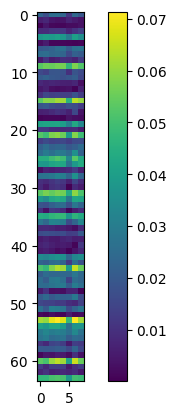

In [97]:
fc= torch.zeros_like(model.fc1[1].weight.data)
k_min=k_plus
for k in range(10):
    
    fc+=k_plus*(fc1_weight_relevance_list[-10+k][k])-k_min*(torch.sum(fc1_weight_relevance_list[-10+k][:k],dim =0)+torch.sum(fc1_weight_relevance_list[-10+k][k+1:],dim =0))#
plt.imshow(torch.abs(fc[:,4600:4650]))
plt.colorbar()

In [92]:
model.conv1.weight.data

tensor([[[[ 0.2184, -0.2868, -0.1775],
          [-0.2817, -0.0720, -0.2737],
          [-0.2281, -0.1347, -0.2424]]],


        [[[ 0.0566, -0.3177,  0.1394],
          [-0.3274, -0.3094,  0.3223],
          [ 0.1703,  0.1219,  0.2587]]],


        [[[ 0.1693, -0.0858, -0.0051],
          [ 0.0390,  0.1916, -0.3077],
          [-0.1559, -0.0355, -0.0699]]],


        [[[-0.2542, -0.1277,  0.1326],
          [ 0.2089, -0.0098,  0.0721],
          [-0.2997,  0.2486,  0.0461]]],


        [[[-0.1253,  0.1732,  0.2981],
          [-0.1249,  0.2997,  0.0274],
          [-0.0969,  0.3301,  0.2411]]],


        [[[ 0.0310,  0.2389, -0.1046],
          [-0.0957,  0.0300,  0.0678],
          [ 0.0623,  0.0926, -0.1638]]],


        [[[-0.3081,  0.1187, -0.1073],
          [-0.0051, -0.0752,  0.0482],
          [ 0.2912, -0.3190, -0.0432]]],


        [[[ 0.1876,  0.0916, -0.1619],
          [-0.1512,  0.0736,  0.2323],
          [-0.1860,  0.2107, -0.2693]]],


        [[[-0.2357,  0.0871, -0.

In [106]:
torch.max(conv1_weight_relevance_list[9][8])

tensor(7.0913e-05)

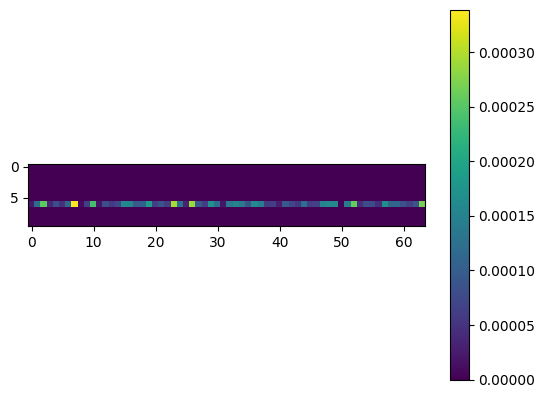

In [71]:
plt.imshow(fc2_weight_relevance_list[5][6][:,:])
plt.colorbar()

In [9]:
best_acc

tensor(47.1600)

In [65]:
i = 9
((i+1)%10) 

0

In [46]:
test = []
for i in range(10):
    test.append(i)

for k in range(10):
    print(test[-10+k],k)

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


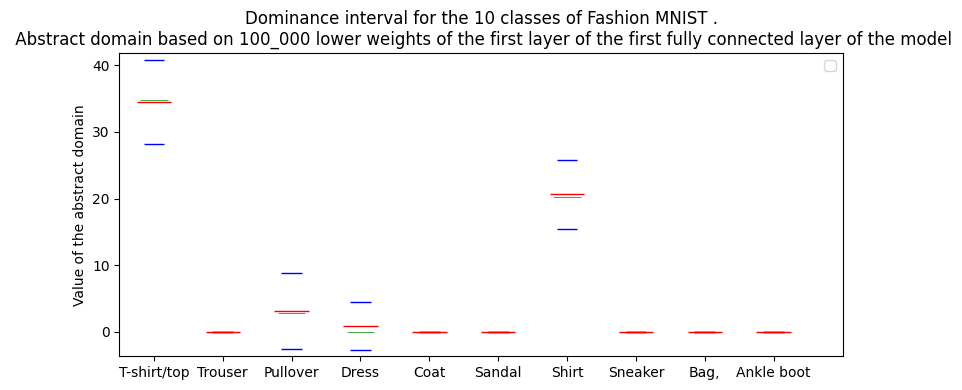

<Axes: title={'center': 'Dominance interval for the 10 classes of Fashion MNIST .\n Abstract domain based on 100_000 lower weights of the first layer of the first fully connected layer of the model'}, ylabel='Value of the abstract domain'>

In [360]:
result = result_list[1]
plot_dominance(*result[:4])

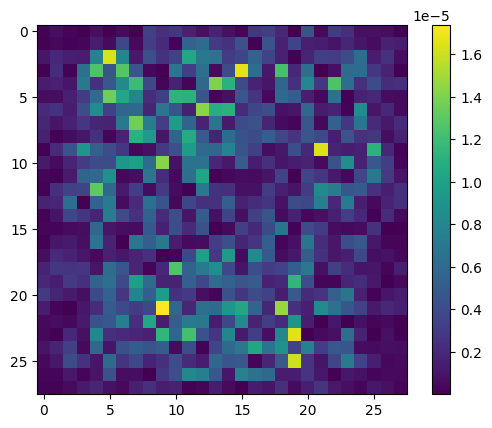

In [109]:

concat= torch.abs(img_relevance_list[0][2])

concat = concat.reshape(28,28)
plt.imshow(torch.abs(concat.cpu()).numpy(), cmap='viridis')
plt.colorbar()

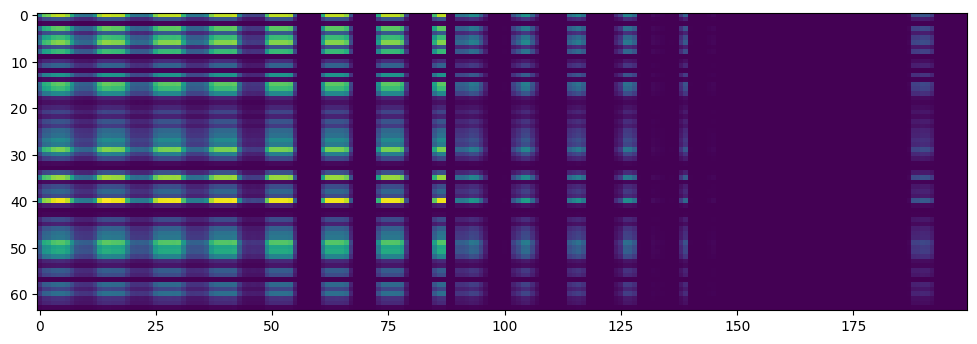

In [108]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.figure(figsize=(12, 6)) 
plt.imshow(torch.abs(fc1_weight_relevance_list[0][1,:,200:400]))




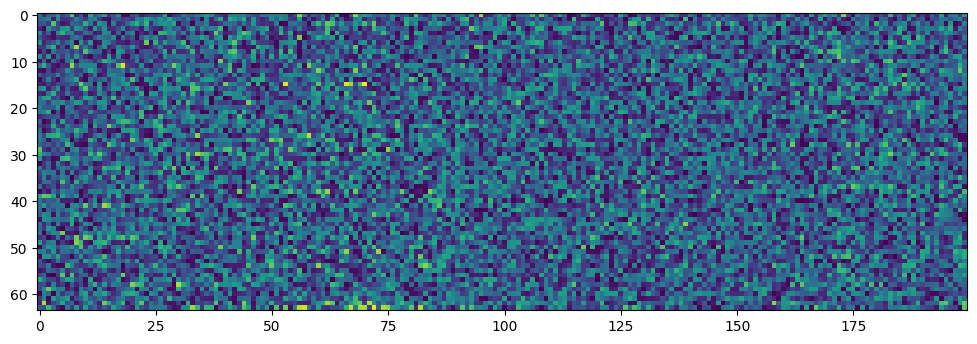

In [107]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.figure(figsize=(12, 6)) 
plt.imshow(torch.abs(model.fc1[1].weight.data[:,200:400]))

In [302]:
label_list_number = np.arange(0,50,1)
label_list_number = np.array([int(label_list_number[i]/10) for i in label_list_number])

In [303]:
label_list_number

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4])

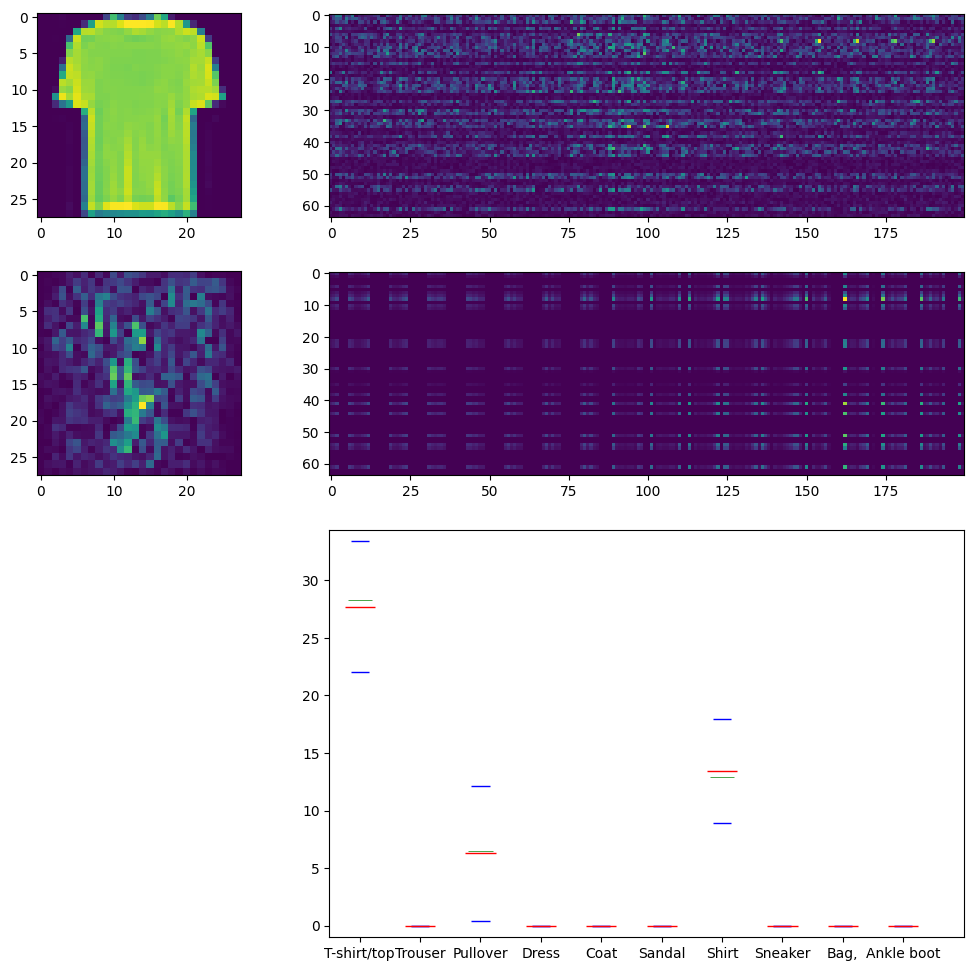

In [418]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

"""
This is the code to create a video of the prediction and the ground truth
It takes the prediction and the ground truth and reshapes them to the original shape of the image.
It then creates a video of the prediction and the ground truth.
"""


array_list_img=np.array(img_list)

array_list_fc1=np.array(fc1_weight_relevance_list)

fig, ax = plt.subplots(3, 2, figsize = (12, 12),gridspec_kw={'width_ratios': [1,3],'height_ratios': [1, 1, 2]})
def init():
    ax[2,1].cla()
    ax[0,0].cla()
    ax[1,0].cla()
    ax[1,1].cla()
    ax[0,1].cla()
   
    ax[0,0].imshow(array_list_img[0][0])
    ax[0,1].imshow(np.abs(model.fc1[1].weight.data[:,200:400]))
    ax[1,0].imshow(np.abs(img_relevance_list[0][0].reshape(28,28)))

    ax[1,1].imshow(np.abs(array_list_fc1[0][label_list_number[0],:,200:400]))
   
    result,y_min,y_max,y_true = result_list[0][:4]
    y_min       =  np.array(y_min)
    y_max       =  np.array(y_max)
    center_Ztp  =  np.expand_dims(np.array(result[0]),axis =1)
    y_true      =  np.expand_dims(np.array(y_true[:])[0],axis =1)



       




    x_scale = np.arange(len(y_min))
    D =np.stack((y_min,y_max),axis=1)

    
    # plot:

    
    ax[2,1].eventplot(D, orientation="vertical", linewidth=1,color='blue',linelengths=0.3)
    ax[2,1].eventplot(y_true, orientation="vertical", linewidth=0.50,color='green',linelengths=0.4)
    ax[2,1].eventplot(center_Ztp, orientation="vertical", linewidth=1,color='red',linelengths=0.5)

    ax[2,1].set(xlim=(-0.5, 10),xticks=x_scale,xticklabels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag,","Ankle boot"],
            ylim=(np.min(D)-1, np.max(D)+1))
    ax[2,0].axis('off')
  
    
 
    return [ax]

def update(frame):
    
    ax[2,1].cla()
    ax[0,0].cla()
    ax[1,0].cla()
    ax[1,1].cla()
    ax[0,1].cla()
   
    ax[0,0].imshow(array_list_img[frame][0])
    ax[0,1].imshow(np.abs(model.fc1[1].weight.data[:,200:400+2*frame]))
    ax[1,0].imshow(np.abs(img_relevance_list[frame][num_label_list[frame]].reshape(28,28)))
   

    ax[1,1].imshow(np.abs(array_list_fc1[frame][num_label_list[frame],:,200:400]))
    result,y_min,y_max,y_true = result_list[frame][:4]
    y_min       =  np.array(y_min)
    y_max       =  np.array(y_max)
    center_Ztp  =  np.expand_dims(np.array(result[0]),axis =1)
    y_true      =  np.expand_dims(np.array(y_true[:])[0],axis =1)



       




    x_scale = np.arange(len(y_min))
    D =np.stack((y_min,y_max),axis=1)

    
    # plot:
    ax[2,1].set(xlim=(-0.5, 10),xticks=x_scale,xticklabels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag,","Ankle boot"],
            ylim=(np.min(D)-1, np.max(D)+1))
    
    ax[2,1].eventplot(D, orientation="vertical", linewidth=1,color='blue',linelengths=0.3)
    ax[2,1].plot([num_label_list[frame], num_label_list[frame]], [y_min[num_label_list[frame]], y_max[num_label_list[frame]]], color='red') 
    ax[2,1].eventplot(y_true, orientation="vertical", linewidth=0.50,color='green',linelengths=0.4)
    ax[2,1].eventplot(center_Ztp, orientation="vertical", linewidth=1,color='red',linelengths=0.5)

    
    ax[2,0].axis('off')


    plt.title(f'Inference over {name_label_list[frame]} ; Relevance of fc1 layer IAW {label_list_number[frame]} label.')

    return [ax]


animation = FuncAnimation(fig, update, frames=50, init_func=init)

output_video = 'Abstract_network_relevance_dominance.mp4'

animation.save(output_video, fps=0.5, extra_args=['-vcodec', 'libx264'])

In [280]:

array = torch.randn(3,3,3)
array

tensor([[[-0.0971,  1.8829,  0.6715],
         [-0.4348, -0.3710, -0.1305],
         [-1.1697,  0.3712, -0.6378]],

        [[-1.8042,  1.0049,  1.1337],
         [ 0.8545,  1.2368, -1.4549],
         [ 0.1998,  0.2309, -0.1748]],

        [[-1.5012,  0.0799, -1.7277],
         [ 0.7552,  0.4155, -0.3586],
         [ 0.4779, -0.1827,  1.2072]]])

In [282]:
array[0][2]

tensor([-1.1697,  0.3712, -0.6378])

In [362]:
import pickle
total_list = [img_list,
img_relevance_list,
conv1_weight_relevance_list, 
conv1_bias_relevance_list,
conv2_weight_relevance_list,
conv2_bias_relevance_list, 

fc1_weight_relevance_list, 
fc1_bias_relevance_list, 
fc2_weight_relevance_list, 
fc2_bias_relevance_list,  
result_list,
num_label_list,
name_label_list, 
true_predict_list] 


file_path = 'my_list.pkl'


with open(file_path, 'wb') as file:
 
    pickle.load(total_list, file)

In [585]:

import pickle
file_path = 'my_list.pkl'


with open(file_path, 'rb') as file:
 
    pickle.load(file)

EOFError: Ran out of input

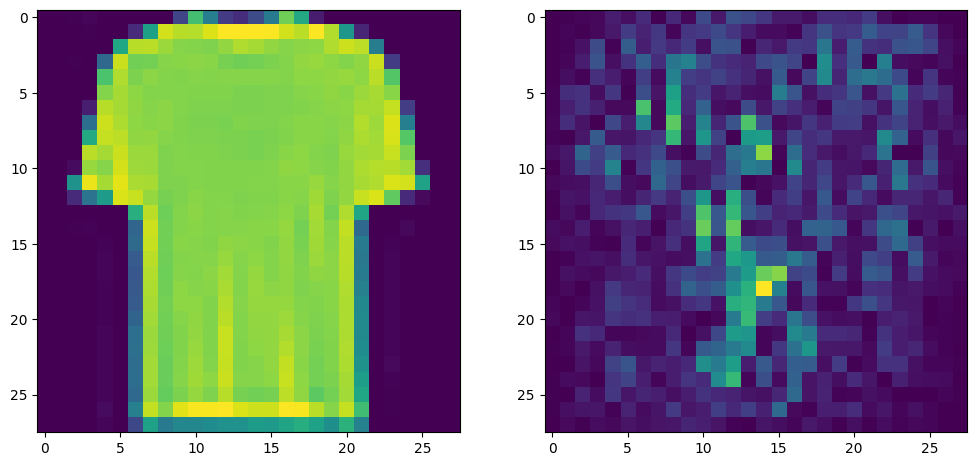

In [423]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

"""
This is the code to create a video of the prediction and the ground truth
It takes the prediction and the ground truth and reshapes them to the original shape of the image.
It then creates a video of the prediction and the ground truth.
"""


array_list_img=np.array(img_list)

array_list_fc1=np.array(fc1_weight_relevance_list)

fig, ax = plt.subplots(1, 2, figsize = (12, 6),gridspec_kw={'width_ratios': [1,1]})
def init():
  
   
    ax[0].imshow(array_list_img[0][0])

    ax[1].imshow(np.abs(img_relevance_list[0][0].reshape(28,28)))

    
  
    
 
    return [ax]

def update(frame):
    
  
   
    ax[0].imshow(array_list_img[frame+20][0])

    ax[1].imshow(np.abs(img_relevance_list[frame+20][num_label_list[frame+20]].reshape(28,28)))
   






    return [ax]


animation = FuncAnimation(fig, update, frames=20, init_func=init)

output_video = 'Abstract_network_relevance.mp4'

animation.save(output_video, fps=0.5, extra_args=['-vcodec', 'libx264'])

  0%|          | 0/10 [00:00<?, ?it/s]

0
tensor(-128.0965)
torch.Size([2, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


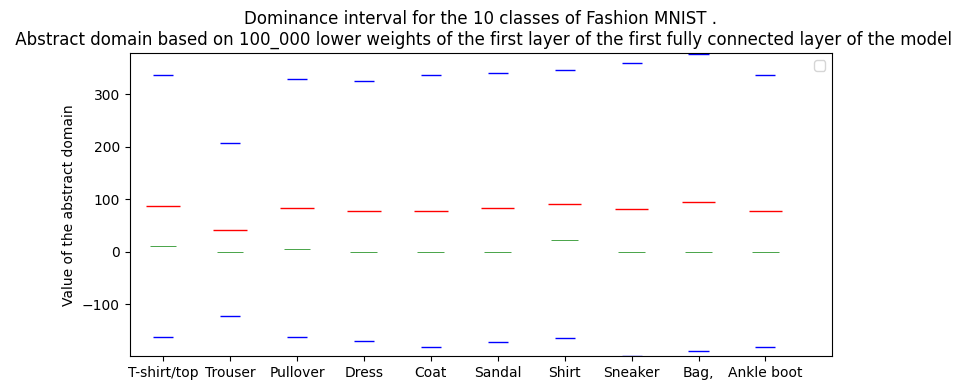

 10%|█         | 1/10 [00:15<02:21, 15.77s/it]

1
tensor(-128.0965)
torch.Size([2, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


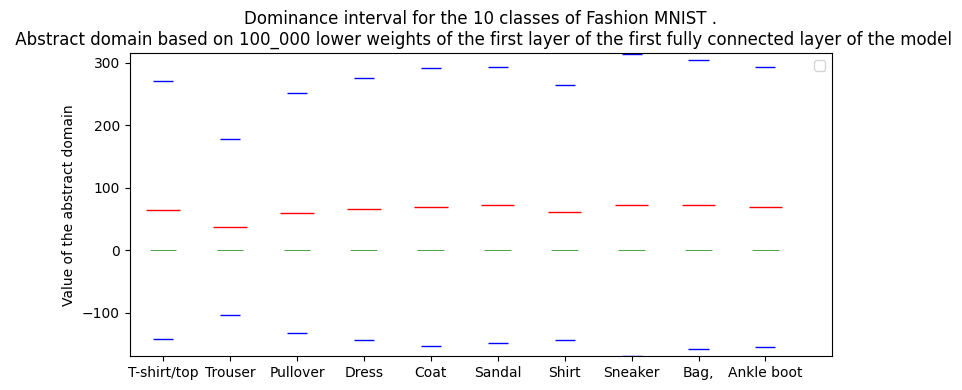

 20%|██        | 2/10 [00:45<03:11, 23.93s/it]

2
tensor(-128.0965)
torch.Size([2, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


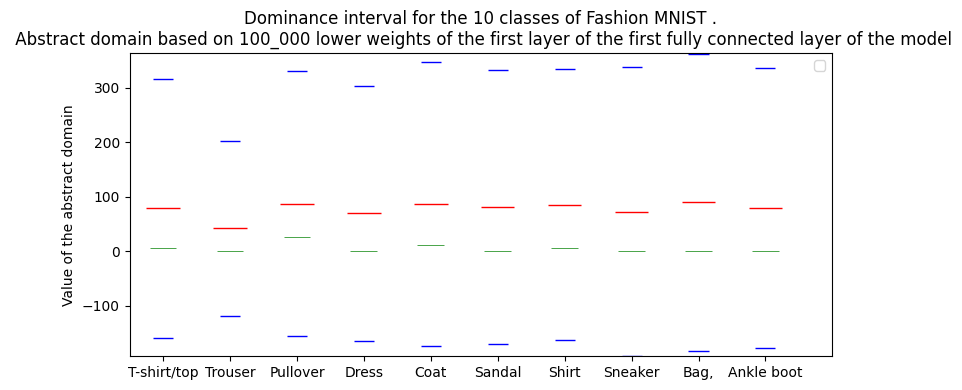

 30%|███       | 3/10 [01:02<02:24, 20.63s/it]

3
tensor(-128.0965)
torch.Size([2, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


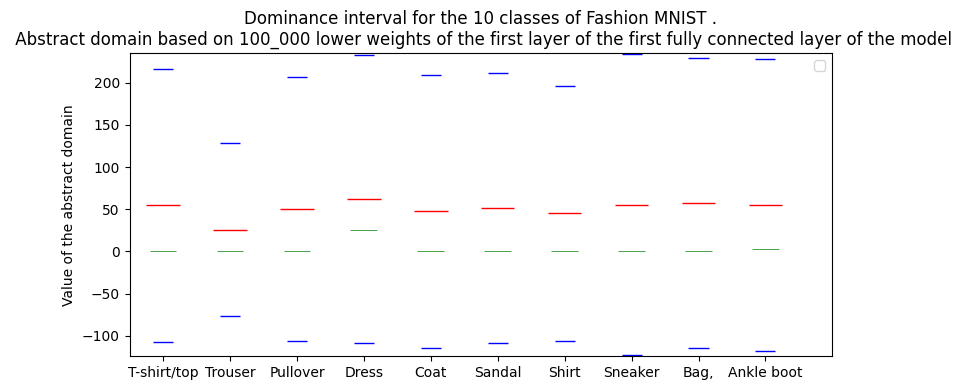

 40%|████      | 4/10 [01:35<02:33, 25.54s/it]

4
tensor(-128.0965)
torch.Size([2, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


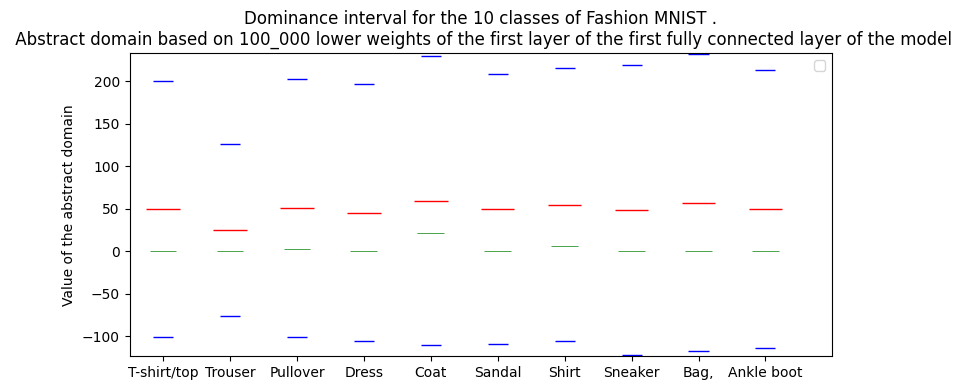

 50%|█████     | 5/10 [02:08<02:21, 28.34s/it]

5
tensor(-128.0965)
torch.Size([2, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


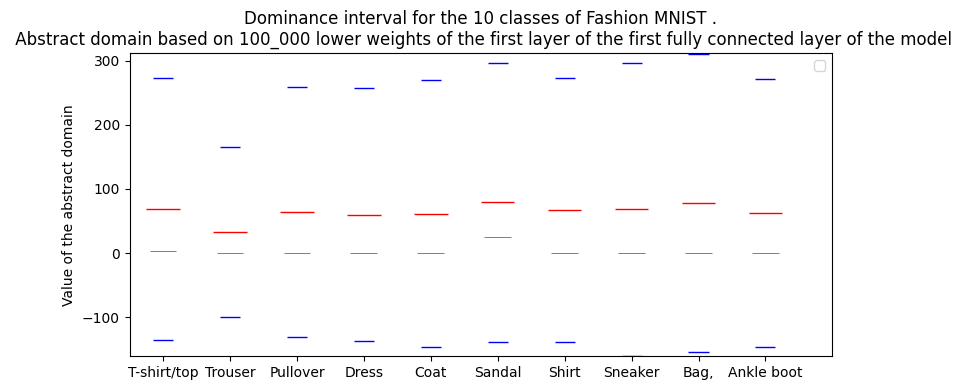

 60%|██████    | 6/10 [02:26<01:39, 24.92s/it]

6
tensor(-128.0965)
torch.Size([2, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


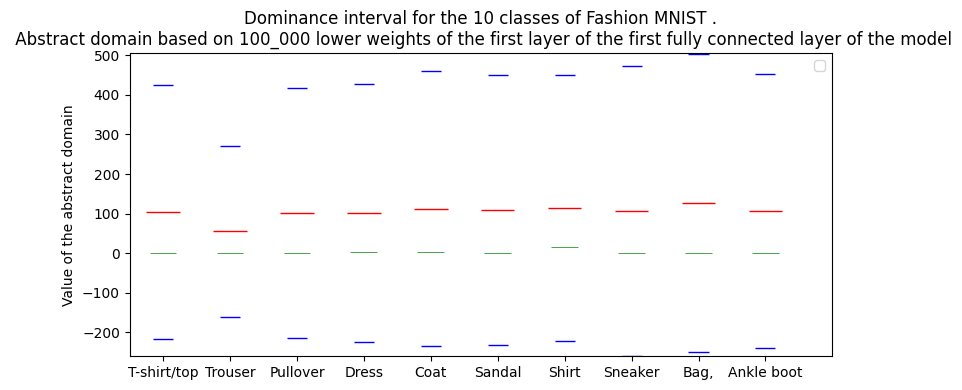

 70%|███████   | 7/10 [02:43<01:07, 22.35s/it]

7
tensor(-128.0965)
torch.Size([2, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


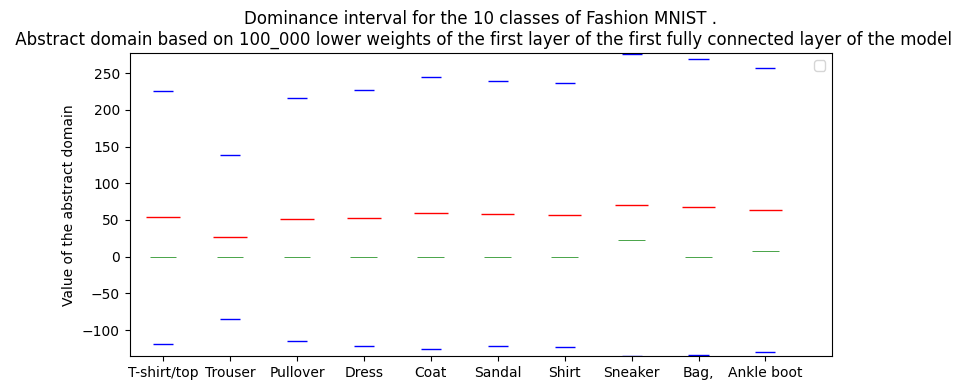

 80%|████████  | 8/10 [03:01<00:41, 20.86s/it]

8
tensor(-128.0965)
torch.Size([2, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


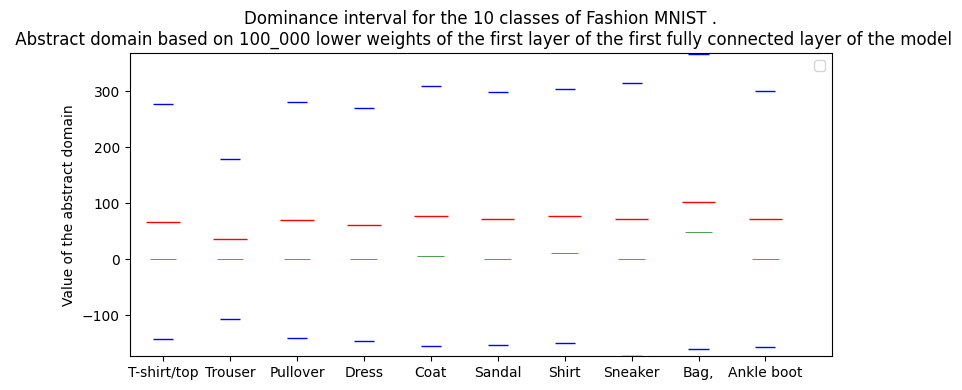

 90%|█████████ | 9/10 [03:18<00:19, 19.71s/it]

9
tensor(-128.0965)
torch.Size([2, 1, 28, 28])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10, 2)
(10, 1)
(10, 1)


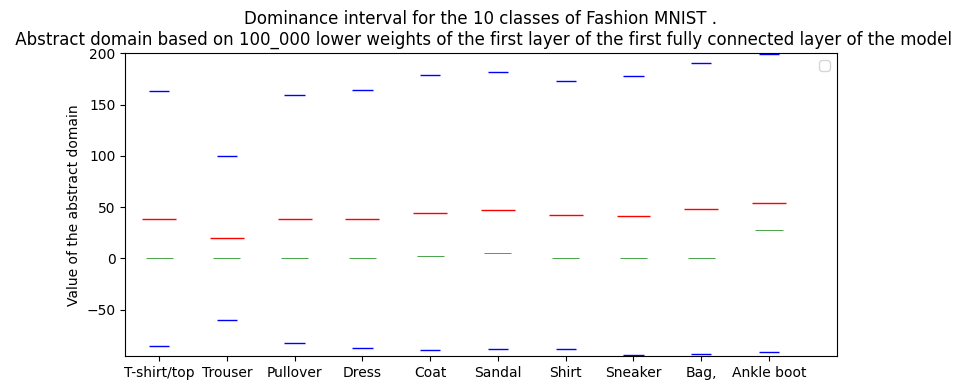

100%|██████████| 10/10 [03:38<00:00, 21.82s/it]


In [549]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from abstract import abstractTensor as AT
abstract_network = False
scale =0.01
xticklabels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag,","Ankle boot"]

img_list = []
img_relevance_list =[]
conv1_weight_relevance_list = []
conv1_bias_relevance_list = []
conv2_weight_relevance_list = []
conv2_bias_relevance_list = []

fc1_weight_relevance_list = []
fc1_bias_relevance_list = []
fc2_weight_relevance_list = []
fc2_bias_relevance_list  = []
result_list =[]
num_label_list = []
name_label_list = []
true_predict_list = []




for i in tqdm(range(10)):
    print(i)
    if i%10 ==0:
        scale = 0.01/(i/10+1)
    if abstract_network : 
    
        conv1_eps_weight = torch.tensor([])
        conv1__weight_span = torch.max(model.conv1.weight.data.flatten())-torch.min(model.conv1.weight.data.flatten())
        conv1_eps_weight.indices = torch.arange(0,len(model.conv1.weight.data.flatten()),1)
        conv1_eps_weight.values = scale*conv1__weight_span*torch.ones_like(conv1_eps_weight.indices)
        conv1_eps_bias = torch.tensor([])
        conv1__bias_span = torch.max(model.conv1.bias.data.flatten())-torch.min(model.conv1.bias.data.flatten())
        conv1_eps_bias.indices = torch.arange(0,len(model.conv1.bias.data.flatten()),1)
        conv1_eps_bias.values = scale*conv1__bias_span*torch.ones_like(conv1_eps_bias.indices)


        conv2_eps_weight = torch.tensor([])
        conv2_eps_weight.indices = torch.arange(0,len(model.conv2.weight.data.flatten()),1)
        conv2_weight_span = torch.max(model.conv2.weight.data.flatten())-torch.min(model.conv2.weight.data.flatten())
        conv2_eps_weight.values = scale*conv2_weight_span*torch.ones_like(conv2_eps_weight.indices)
        conv2_eps_bias = torch.tensor([])
        conv2_eps_bias.indices = torch.arange(0,len(model.conv2.bias.data.flatten()),1)
        conv2_bias_span = torch.max(model.conv2.bias.data.flatten())-torch.min(model.conv2.bias.data.flatten())
        conv2_eps_bias.values = scale/2*conv2_bias_span*torch.ones_like(conv2_eps_bias.indices)

        fc1_eps_weight = torch.tensor([])
        fc1_weight_span = torch.max(model.fc1[1].weight.data.flatten())-torch.min(model.fc1[1].weight.data.flatten())
        fc1_eps_weight.indices = torch.arange(0,len(model.fc1[1].weight.data.flatten()),1)
        fc1_eps_weight.values = scale/1*fc1_weight_span*torch.ones_like(fc1_eps_weight.indices)
        fc1_eps_bias = torch.tensor([])
        fc1_bias_span = torch.max(model.fc1[1].bias.data.flatten())-torch.min(model.fc1[1].bias.data.flatten())
        fc1_eps_bias.indices = torch.arange(0,len(model.fc1[1].bias.data.flatten()),1)
        fc1_eps_bias.values = scale/1*fc1_bias_span*torch.ones_like(fc1_eps_bias.indices)


        fc2_eps_weight = torch.tensor([])
        fc2_weight_span = torch.max(model.fc2[1].weight.data.flatten())-torch.min(model.fc2[1].weight.data.flatten())
        fc2_eps_weight.indices = torch.arange(0,len(model.fc2[1].weight.data.flatten()),1)
        fc2_eps_weight.values = scale/100*fc2_weight_span*torch.ones_like(fc2_eps_weight.indices)
        fc2_eps_bias = torch.tensor([])
        fc2_bias_span = torch.max(model.fc2[1].bias.data.flatten())-torch.min(model.fc2[1].bias.data.flatten())
        fc2_eps_bias.indices = torch.arange(0,len(model.fc2[1].bias.data.flatten()),1)
        fc2_eps_bias.values = scale/100*fc2_bias_span*torch.ones_like(fc2_eps_bias.indices)


    else :
        conv1_eps_weight = make_indice_and_values_tupple()
        conv1_eps_bias = make_indice_and_values_tupple()
       

        conv2_eps_weight = make_indice_and_values_tupple()
        conv2_eps_bias = make_indice_and_values_tupple()
        
        for param in model.named_parameters():
            if param[0] == 'fc1.1.weight':
                    print(torch.sum(param[1].data))        
                    index = torch.topk(torch.abs(param[1].data).flatten(),k=294912,largest=False)
                    mat= param[1].data
            

                    alpha= 1.1*torch.abs(index.values)

        fc1_eps_bias = make_indice_and_values_tupple()
        
        fc1_eps_weight = make_indice_and_values_tupple()
        fc1_eps_weight.indices = index.indices
        fc1_eps_weight.values = alpha
        fc2_eps_weight = make_indice_and_values_tupple()
        fc2_eps_bias = make_indice_and_values_tupple()




    label = None

  
    while label!= i: 
        index = np.random.randint(0,5000)
        
        img, label = dataset_train[index]

    name_label_list.append(xticklabels[label])
    num_label_list.append(label)
   
    img_list.append(img)
    
    x=AT(img,alpha =torch.tensor([]))
    x=x.abstract_tensor()
    print(x.shape)

    
  
    with torch.no_grad():
      
        
        result,x_min,x_max,x_true,len_symb, len_symb_c2, len_symb_fc1=model.abstract_forward(x,
                                                                    conv1_eps_bias=conv1_eps_bias,
                                                                    conv1_eps_weight=conv1_eps_weight,
                                                                    conv2_eps_weight = conv2_eps_weight,
                                                                    conv2_eps_bias = conv2_eps_bias,

                                                                    fc1_eps_weight =fc1_eps_weight,
                                                                    fc1_eps_bias = fc1_eps_bias, 
                                                                    fc2_eps_weight = fc2_eps_weight,
                                                                    fc2_eps_bias = fc2_eps_bias,

                                                                    add_symbol=True)
        
    result_list.append([result,x_min,x_max,x_true,len_symb, len_symb_c2, len_symb_fc1])    
    true_predict_list.append(torch.argmax(x_true))
    plot_dominance(result,x_min,x_max,x_true)
    


    concatenated_tensors = []
    concatenated_heatmap_tensors =[]
    for j in range(10):
        concat_part =result[1:785,j]
        concatenated_heatmap_tensors.append(concat_part)
    concatenated_heatmap_tensors = torch.stack(concatenated_heatmap_tensors)

    img_relevance_list.append(concatenated_heatmap_tensors)

  
    if abstract_network:

        conv1_weight_concatenated_tensors = []
        conv1_bias_concatenated_tensors =[]
        for j in range(10):
            concat_part = result[len(x)-1:len(x)+143, j].view(16, 1, 3, 3)
            conv1_weight_concatenated_tensors.append(concat_part)
        conv1_weight_concatenated_tensors =torch.stack(conv1_weight_concatenated_tensors)
        for j in range(10):
            concat_part= result[len(x)+143:len(x)+159, j]
            conv1_bias_concatenated_tensors .append(concat_part)
        conv1_bias_concatenated_tensors = torch.stack(conv1_bias_concatenated_tensors )

        conv2_weight_concatenated_tensors = []
        conv2_bias_concatenated_tensors =[]
        for j in range(10):
            concat_part = result[len_symb-1:len_symb+4607, j].view(32, 16, 3, 3)
            conv2_weight_concatenated_tensors.append(concat_part)
        conv2_weight_concatenated_tensors =torch.stack(conv2_weight_concatenated_tensors)
        for j in range(10):
            concat_part = result[len_symb+4607:len_symb+4639, j]
            conv2_bias_concatenated_tensors.append(concat_part)
        conv2_bias_concatenated_tensors = torch.stack(conv2_bias_concatenated_tensors)

        fc1_weight_concatenated_tensors = []
        fc1_bias_concatenated_tensors =[]
        for j in range(10):
            concat_part = result[len_symb_c2-1:len_symb_c2+294911, j].reshape(64,4608)
            fc1_weight_concatenated_tensors.append(concat_part)
        fc1_weight_concatenated_tensors =torch.stack(fc1_weight_concatenated_tensors)
        for j in range(10):
            concat_part = result[len_symb_c2+294911:len_symb_c2+294975, j]
            fc1_bias_concatenated_tensors.append(concat_part)
        fc1_bias_concatenated_tensors= torch.stack(fc1_bias_concatenated_tensors)

        fc2_weight_concatenated_tensors = []
        fc2_bias_concatenated_tensors =[]
        for j in range(10):
            concat_part = result[len_symb_fc1-1:len_symb_fc1+639, j].view(10,64)
            fc2_weight_concatenated_tensors.append(concat_part)
        fc2_weight_concatenated_tensors =torch.stack(fc2_weight_concatenated_tensors)
        for j in range(10):
            concat_part = result[len_symb_fc1+639:len_symb_fc1+649, j]
            fc2_bias_concatenated_tensors.append(concat_part)
        fc2_bias_concatenated_tensors= torch.stack(fc2_bias_concatenated_tensors)

    


        conv1_weight_relevance_list.append(conv1_weight_concatenated_tensors)
        conv1_bias_relevance_list.append(conv1_bias_concatenated_tensors)
        conv2_weight_relevance_list.append(conv2_weight_concatenated_tensors)

        conv2_bias_relevance_list.append(conv2_bias_concatenated_tensors)

        fc1_weight_relevance_list.append(fc1_weight_concatenated_tensors)
        fc1_bias_relevance_list.append(fc1_bias_concatenated_tensors)
        fc2_weight_relevance_list.append(fc2_weight_concatenated_tensors)
        fc2_bias_relevance_list.append(fc2_bias_concatenated_tensors)

    else :
        fc1_bias_concatenated_tensors =[]
        fc1_weight_concatenated_tensors = []
        for j in range(10):
            concat_part = result[len_symb_c2-1:len_symb_c2+294911, j]#.reshape(64,4608)
            fc1_weight_concatenated_tensors.append(concat_part)
        fc1_weight_concatenated_tensors =torch.stack(fc1_weight_concatenated_tensors)


    fc1_weight_relevance_list.append(fc1_weight_concatenated_tensors)

    """
    k_min = 0.01
    k_plus = 0.6
    if i>9:
        k_plus = 0.5
        k_min = 0.05
    if i>19:
        k_plus = 0.4
        k_min = 0.1
    if i>39:
        k_min = 0.2
    """
    
    """
    model.conv1.weight.data =model.conv1.weight.data+k_plus*(concatenated_tensors[label]-k_min*(torch.sum(concatenated_tensors[:label],dim =0)+torch.sum(concatenated_tensors[label+1:],dim =0)))#/torch.norm(2*concatenated_tensors[label]-torch.sum(concatenated_tensors,dim =0))
    model.conv1.bias.data = model.conv1.bias.data + k_plus*(concatenated_bias_tensors[label]-k_min*(torch.sum(concatenated_bias_tensors[:label],dim = 0)+torch.sum(concatenated_bias_tensors[label+1:],dim = 0)))#/torch.norm(2*concatenated_bias_tensors[label]-torch.sum(concatenated_bias_tensors,dim = 0))

    model.conv2.weight.data =model.conv2.weight.data+k_plus*(concatenated_tensors_2[label]-k_min*(torch.sum(concatenated_tensors_2[:label],dim =0)+torch.sum(concatenated_tensors_2[label+1:],dim =0)))#/torch.norm(2*concatenated_tensors[label]-torch.sum(concatenated_tensors,dim =0))
    model.conv2.bias.data = model.conv2.bias.data + k_plus*(concatenated_bias_tensors_2[label]-k_min*(torch.sum(concatenated_bias_tensors_2[:label],dim = 0)+torch.sum(concatenated_bias_tensors_2[label+1:],dim = 0)))#/torch.norm(2*concatenated_bias_tensors[label]-torch.sum(concatenated_bias_tensors,dim = 0))

    model.fc1[1].weight.data =model.fc1[1].weight.data+k_plus*(concatenated_tensors_fc1[label]-k_min*(torch.sum(concatenated_tensors_fc1[:label],dim =0)+torch.sum(concatenated_tensors_fc1[label+1:],dim =0)))#/torch.norm(2*concatenated_tensors[label]-torch.sum(concatenated_tensors,dim =0))
    model.fc1[1].bias.data = model.fc1[1].bias.data + k_plus*(concatenated_bias_tensors_fc1[label]-k_min*(torch.sum(concatenated_bias_tensors_fc1[:label],dim = 0)+torch.sum(concatenated_bias_tensors_fc1[label+1:],dim = 0)))#/torch.norm(2*concatenated_bias_tensors[label]-torch.sum(concatenated_bias_tensors,dim = 0))

    model.fc2[1].weight.data =model.fc2[1].weight.data+k_plus*(concatenated_tensors_fc2[label]-k_min*(torch.sum(concatenated_tensors_fc2[:label],dim =0)+torch.sum(concatenated_tensors_fc2[label+1:],dim =0)))#/torch.norm(2*concatenated_tensors[label]-torch.sum(concatenated_tensors,dim =0))
    model.fc2[1].bias.data = model.fc2[1].bias.data + k_plus*(concatenated_bias_tensors_fc2[label]-k_min*(torch.sum(concatenated_bias_tensors_fc2[:label],dim = 0)+torch.sum(concatenated_bias_tensors_fc2[label+1:],dim = 0)))#/torch.no
    """
   

   
    

    

In [575]:
model.load_state_dict(torch.load('dataset/FMNIST.pth'))
from custom_train import CustomTrainer as CT


In [578]:

eval =CT(model, device = device)
eval.evaluate_model(dataset_test)

EPOCH ACCURACY = 40.94 %


tensor(40.9400)

In [445]:
map_relevance = torch.zeros_like(mat).flatten()
map_original = torch.zeros_like(mat).flatten() 
print(fc1_weight_relevance_list[0][0].shape)
map_relevance[ fc1_eps_weight.indices]=  fc1_weight_relevance_list[0][0]
map_original[ fc1_eps_weight.indices]= mat.flatten()[ fc1_eps_weight.indices]
map_relevance = map_relevance.reshape(mat.shape)
map_original = map_original.reshape(mat.shape)
print(f"map_2.shape = {map_relevance.shape}")

map_normalized_relevance = torch.abs(map_relevance)/torch.abs(map_original)
map_normalized_relevance = torch.where(torch.isnan(map_normalized_relevance), torch.zeros_like(map_normalized_relevance), map_normalized_relevance)


torch.Size([100000])
map_2.shape = torch.Size([64, 4608])


In [548]:
print(map_normalized_relevance.shape)

torch.Size([64, 4608])


In [576]:
map_total_normalised_relevance = []
for i in range(100):
    map_relevance = torch.zeros_like(mat).flatten()
    map_original = torch.zeros_like(mat).flatten() 

    map_relevance[ fc1_eps_weight.indices]=  fc1_weight_relevance_list[0][0]
    map_original[ fc1_eps_weight.indices]= mat.flatten()[ fc1_eps_weight.indices]
    map_relevance = map_relevance.reshape(mat.shape)
    map_original = map_original.reshape(mat.shape)
  

    map_normalized_relevance = torch.abs(map_relevance)/torch.abs(map_original)
    map_normalized_relevance = torch.where(torch.isnan(map_normalized_relevance), torch.zeros_like(map_normalized_relevance), map_normalized_relevance)
    print(torch.min(map_normalized_relevance))
    map_total_normalised_relevance.append(map_normalized_relevance)
map_total_normalised_relevance= torch.stack(map_total_normalised_relevance)
print(map_total_normalised_relevance.shape)
map_total_normalised_relevance = torch.sum(map_total_normalised_relevance, dim =0)
print(map_total_normalised_relevance.shape)



tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)

In [577]:
print(torch.max(map_total_normalised_relevance))
mask =torch.where(map_total_normalised_relevance>5,1,0)
print(torch.sum(mask))
mask_1 = torch.ones_like(mask)
mask_1.flatten()[fc1_eps_weight.indices] = 0
print(torch.sum(mask_1))
mask_1 +=mask
print(torch.sum(mask_1))

model.fc1[1].weight.data *=mask_1

tensor(37.8432)
tensor(12547)
tensor(0)
tensor(12547)


In [523]:
torch.sum(mask_1)

tensor(208793)

plt.imshow

torch.Size([100000])
torch.Size([100000])


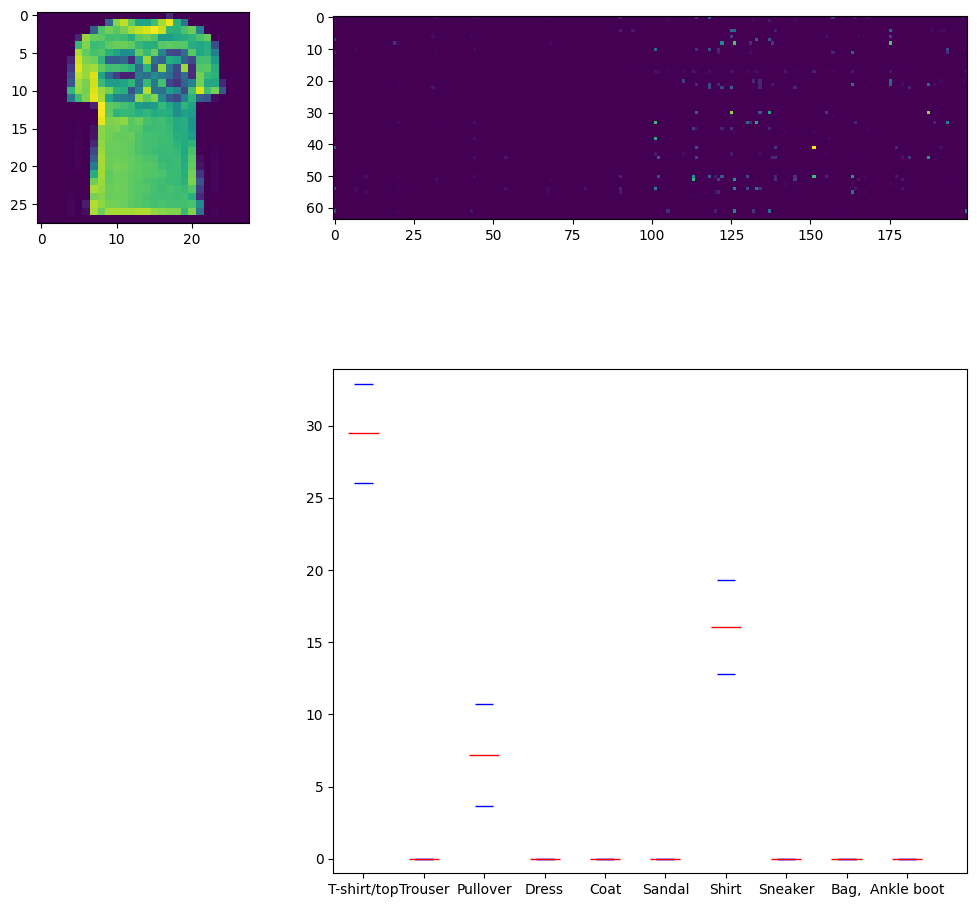

In [454]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

"""
This is the code to create a video of the prediction and the ground truth
It takes the prediction and the ground truth and reshapes them to the original shape of the image.
It then creates a video of the prediction and the ground truth.
"""


array_list_img=np.array(img_list)

array_list_fc1=np.array(fc1_weight_relevance_list)

fig, ax = plt.subplots(2, 2, figsize = (12, 12),gridspec_kw={'width_ratios': [1,3],'height_ratios': [1, 1.5]})
def init():

    ax[0,0].cla()
    ax[1,0].cla()
    ax[1,1].cla()
    ax[0,1].cla()
   
    ax[0,0].imshow(array_list_img[0][0])
    map_relevance = torch.zeros_like(mat).flatten()
    map_original = torch.zeros_like(mat).flatten() 
    print(fc1_weight_relevance_list[0][0].shape)
    map_relevance[ fc1_eps_weight.indices]=  fc1_weight_relevance_list[0][0]
    map_original[ fc1_eps_weight.indices]= mat.flatten()[ fc1_eps_weight.indices]
    map_relevance = map_relevance.reshape(mat.shape)
    map_original = map_original.reshape(mat.shape)
 

    map_normalized_relevance = torch.abs(map_relevance)/torch.abs(map_original)
    map_normalized_relevance = torch.where(torch.isnan(map_normalized_relevance), torch.zeros_like(map_normalized_relevance), map_normalized_relevance)


    ax[0,1].imshow(map_normalized_relevance[:,200:400])



    result,y_min,y_max,y_true = result_list[0][:4]
    y_min       =  np.array(y_min)
    y_max       =  np.array(y_max)
    center_Ztp  =  np.expand_dims(np.array(result[0]),axis =1)
    y_true      =  np.expand_dims(np.array(y_true[:])[0],axis =1)



       




    x_scale = np.arange(len(y_min))
    D =np.stack((y_min,y_max),axis=1)

    
    # plot:

    
    ax[1,1].eventplot(D, orientation="vertical", linewidth=1,color='blue',linelengths=0.3)
    ax[1,1].eventplot(y_true, orientation="vertical", linewidth=0.50,color='green',linelengths=0.4)
    ax[1,1].eventplot(center_Ztp, orientation="vertical", linewidth=1,color='red',linelengths=0.5)

    ax[1,1].set(xlim=(-0.5, 10),xticks=x_scale,xticklabels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag,","Ankle boot"],
            ylim=(np.min(D)-1, np.max(D)+1))
    ax[1,0].axis('off')
  
    
 
    return [ax]

def update(frame):
    ax[0,0].cla()
    ax[1,0].cla()
    ax[1,1].cla()
    ax[0,1].cla()
   
    ax[0,0].imshow(array_list_img[frame+20][0])
    map_relevance = torch.zeros_like(mat).flatten()
    map_original = torch.zeros_like(mat).flatten() 

    map_relevance[ fc1_eps_weight.indices]=  fc1_weight_relevance_list[frame+20][num_label_list[frame+20]]
    map_original[ fc1_eps_weight.indices]= mat.flatten()[ fc1_eps_weight.indices]
    map_relevance = map_relevance.reshape(mat.shape)
    map_original = map_original.reshape(mat.shape)
 

    map_normalized_relevance = torch.abs(map_relevance)/torch.abs(map_original)
    map_normalized_relevance = torch.where(torch.isnan(map_normalized_relevance), torch.zeros_like(map_normalized_relevance), map_normalized_relevance)


    ax[0,1].imshow(map_normalized_relevance[:,200:400])



    result,y_min,y_max,y_true = result_list[frame+20][:4]
    y_min       =  np.array(y_min)
    y_max       =  np.array(y_max)
    center_Ztp  =  np.expand_dims(np.array(result[0]),axis =1)
    y_true      =  np.expand_dims(np.array(y_true[:])[0],axis =1)



       




    x_scale = np.arange(len(y_min))
    D =np.stack((y_min,y_max),axis=1)

    
    # plot:

    
    ax[1,1].eventplot(D, orientation="vertical", linewidth=1,color='blue',linelengths=0.3)
    ax[1,1].eventplot(y_true, orientation="vertical", linewidth=0.50,color='green',linelengths=0.4)
    ax[1,1].eventplot(center_Ztp, orientation="vertical", linewidth=1,color='red',linelengths=0.5)

    ax[1,1].set(xlim=(-0.5, 10),xticks=x_scale,xticklabels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag,","Ankle boot"],
            ylim=(np.min(D)-1, np.max(D)+1))
    ax[1,0].axis('off')
    
 

    return [ax]


animation = FuncAnimation(fig, update, frames=50, init_func=init)

output_video = 'Abstract_network_relevance_dominance.mp4'

animation.save(output_video, fps=0.5, extra_args=['-vcodec', 'libx264'])

In [465]:
x = np.random.randn(1000)
y = np.random.randn(1000)


(-5.0, 5.0)

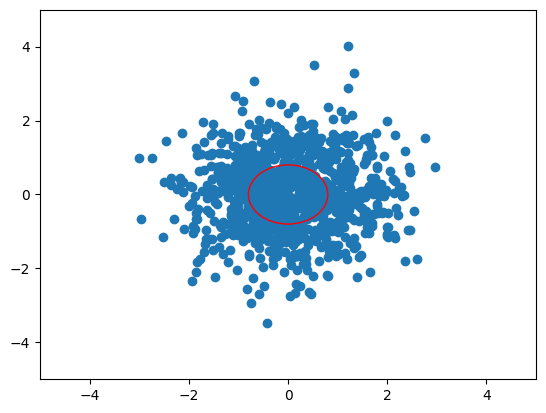

In [472]:
circle_center = (0, 0)
circle_radius = 0.8

# Création de la figure et de l'axe
fig, ax = plt.subplots()

# Scatter plot
ax.scatter(x, y)

# Création du cercle
circle = plt.Circle(circle_center, circle_radius, color='r', fill=False)

# Ajout du cercle à l'axe
ax.add_patch(circle)

# Définir les limites de l'axe pour s'assurer que le cercle est visible
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)


In [ ]:
x = np.random.randn(1000)
y = np.random.randn(1000)

x

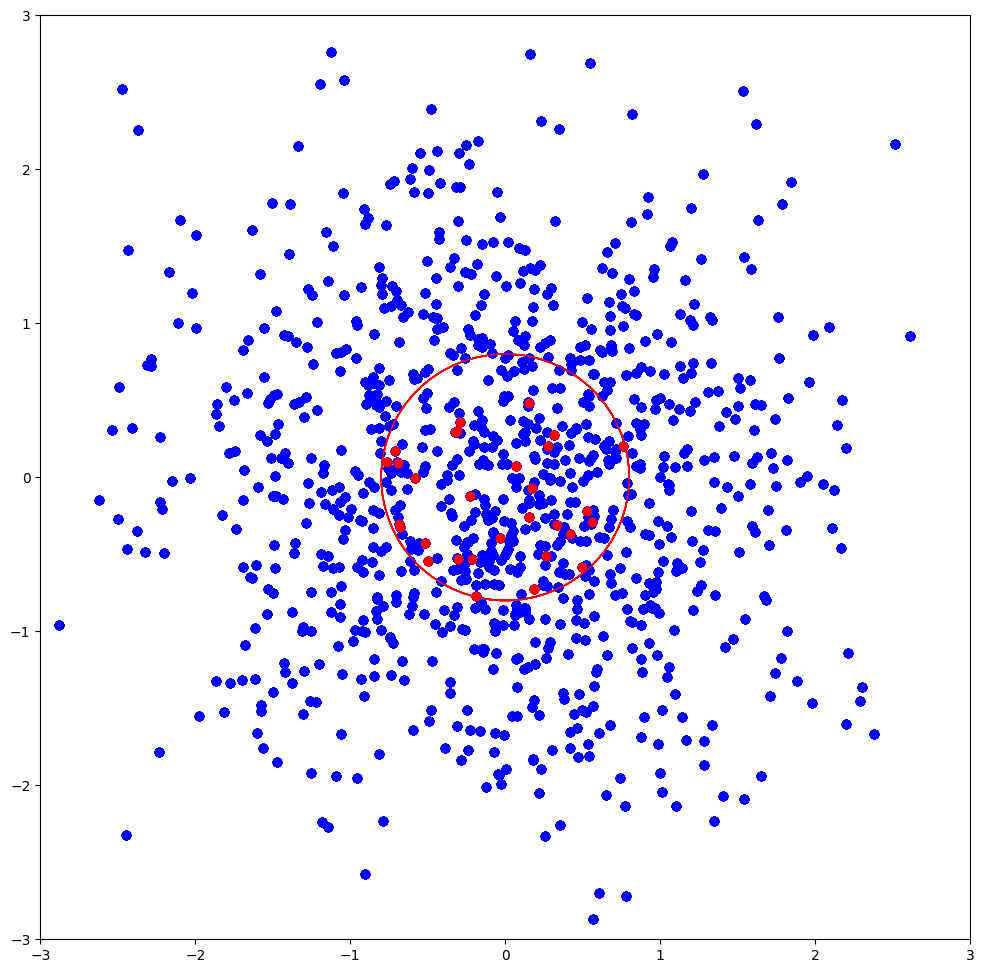

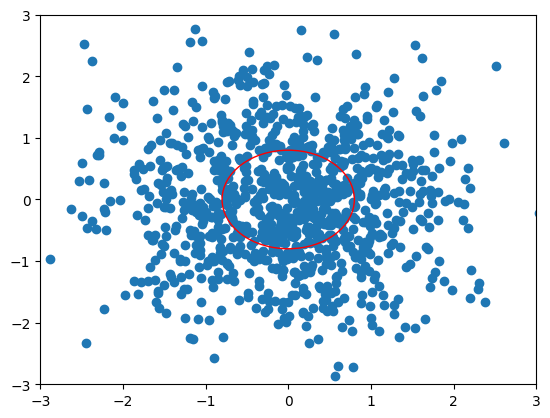

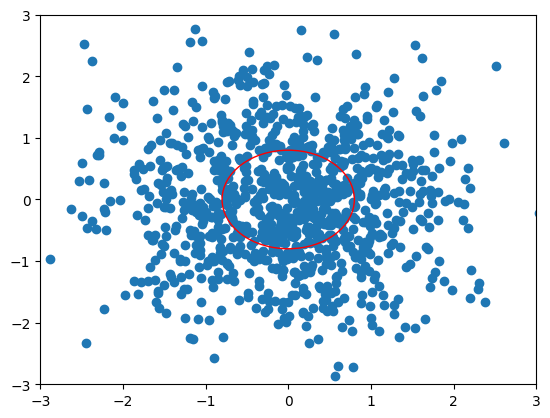

In [489]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(1, 1, figsize = (12, 12))

x = np.random.randn(1000)
y = np.random.randn(1000)
x_red =[]
y_red =[]


def init():

    circle_center = (0, 0)
    circle_radius = 0.8

    # Création de la figure et de l'axe
    fig, ax = plt.subplots()

    # Scatter plot
    ax.scatter(x, y)

    # Création du cercle
    circle = plt.Circle(circle_center, circle_radius, color='r', fill=False)

    # Ajout du cercle à l'axe
    ax.add_patch(circle)

    # Définir les limites de l'axe pour s'assurer que le cercle est visible
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    
 
    return [ax]

def update(frame):

    ax.scatter(x, y,color='blue')


    # Définir les limites de l'axe pour s'assurer que le cercle est visible
    circle = plt.Circle(circle_center, circle_radius, color='r', fill=False)

    # Ajout du cercle à l'axe
    ax.add_patch(circle)
  

    dist = np.sqrt(x**2+y**2)


    for el in np.random.randint(0,999,size=10):
        if dist[el]<0.8:
            x_red.append(x[el])
            y_red.append(y[el])
    ax.scatter(x_red, y_red,color = 'red')

    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)

    return [ax]


animation = FuncAnimation(fig, update, frames=10, init_func=init)

output_video = 'Abstract_network_relevance_dominance.mp4'

animation.save(output_video, fps=0.5, extra_args=['-vcodec', 'libx264'])

In [71]:
model = AbstractNN()
from custom_train import CustomTrainer as CT
print(f"Update parameter after EPOCH {i%10}")
eval =CT(model, device = device)
eval.evaluate_model(dataset_test)

Update parameter after EPOCH 9
EPOCH ACCURACY = 11.25 %


tensor(11.2500)

  0%|          | 0/500 [00:00<?, ?it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


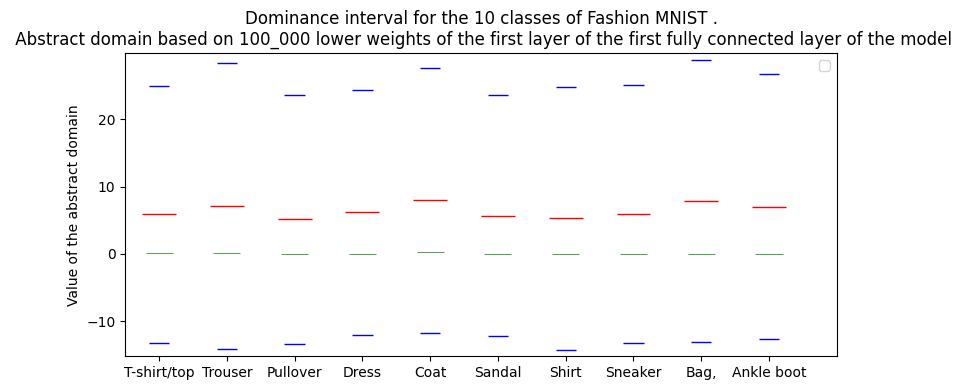

  1%|          | 5/500 [02:36<4:17:53, 31.26s/it]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


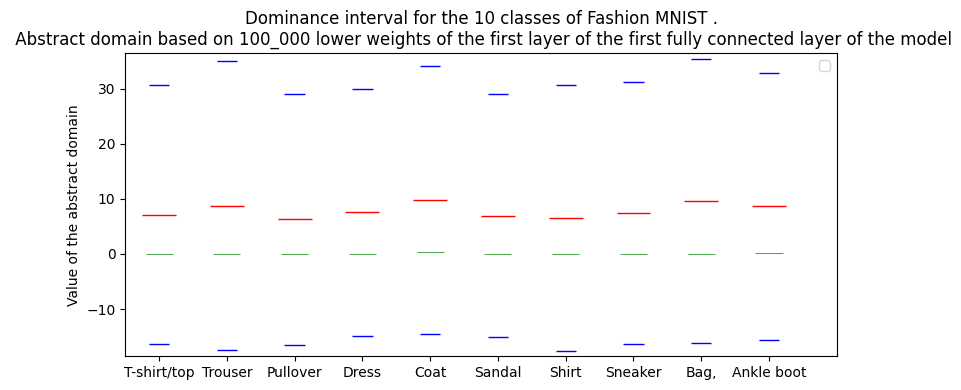

  2%|▏         | 9/500 [05:00<4:45:59, 34.95s/it]

Update parameter after EPOCH 9
Update parameter after EPOCH 9


/home/guillaume/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  2%|▏         | 10/500 [05:24<4:19:37, 31.79s/it]

EPOCH ACCURACY = 11.27 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


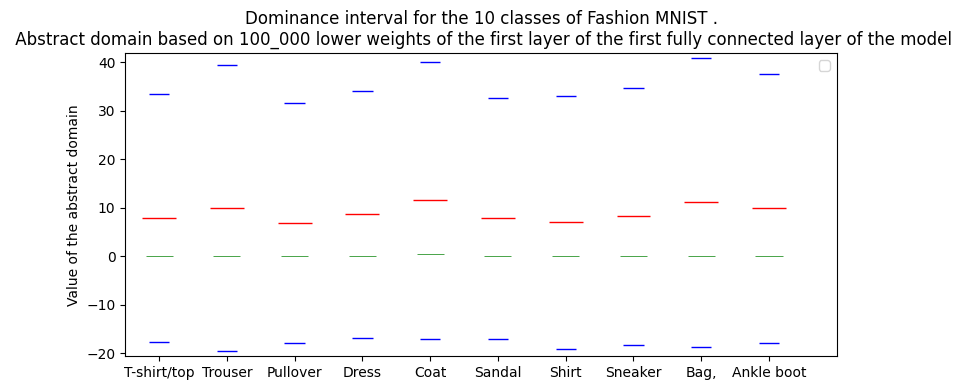

  3%|▎         | 15/500 [07:43<3:55:42, 29.16s/it]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


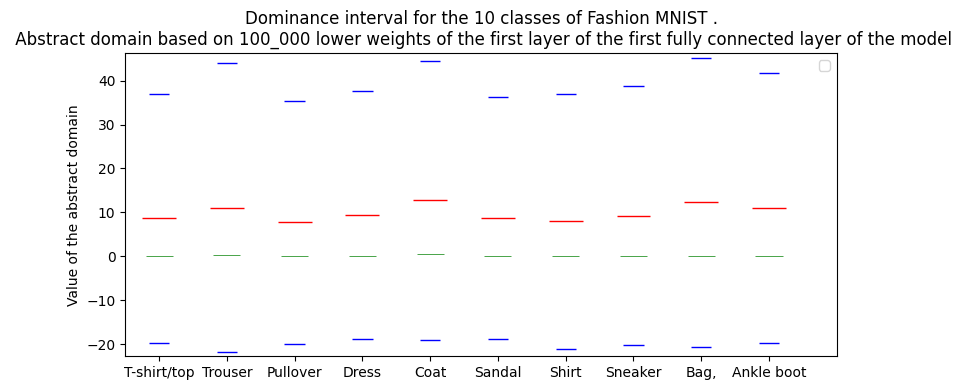

  4%|▍         | 19/500 [09:41<3:45:07, 28.08s/it]

Update parameter after EPOCH 9
Update parameter after EPOCH 9


/home/guillaume/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  4%|▍         | 20/500 [10:13<3:52:48, 29.10s/it]

EPOCH ACCURACY = 11.24 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


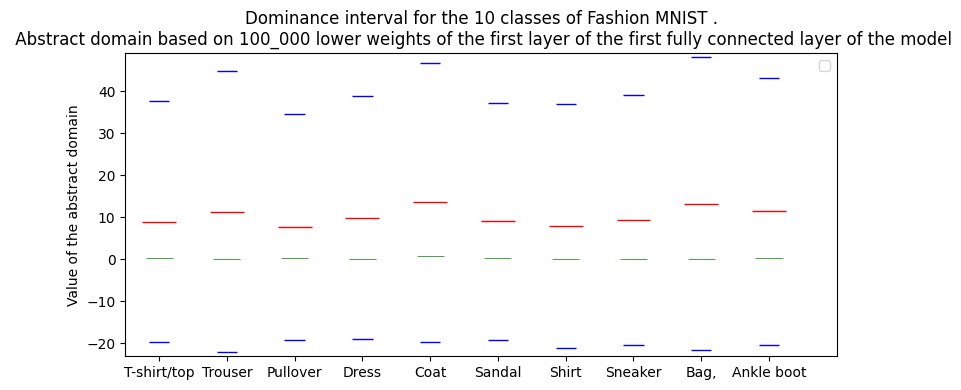

  5%|▌         | 25/500 [12:33<3:31:43, 26.74s/it]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


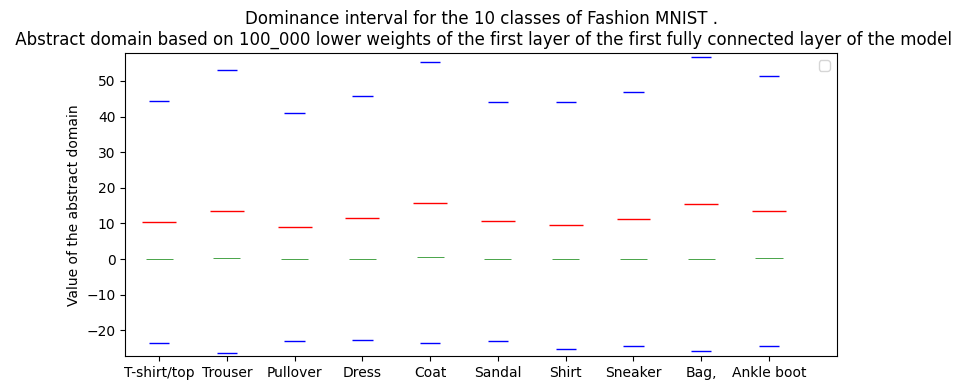

  6%|▌         | 29/500 [15:07<4:37:25, 35.34s/it]

Update parameter after EPOCH 9
Update parameter after EPOCH 9


/home/guillaume/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  6%|▌         | 30/500 [15:45<4:44:34, 36.33s/it]

EPOCH ACCURACY = 11.22 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


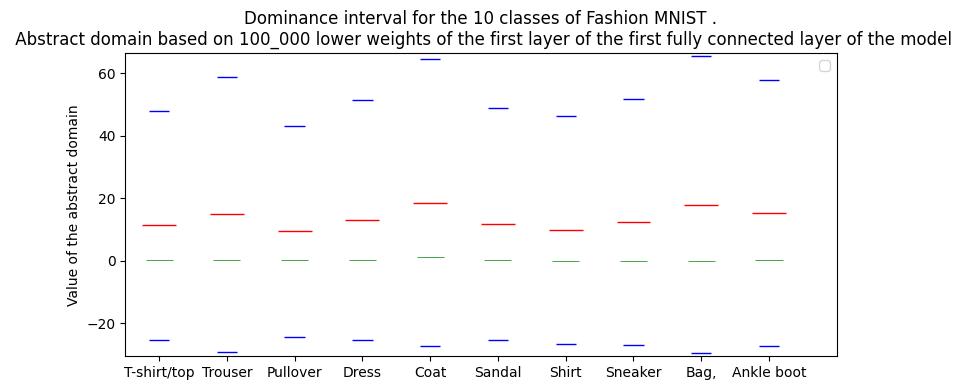

  7%|▋         | 35/500 [18:19<3:51:38, 29.89s/it]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


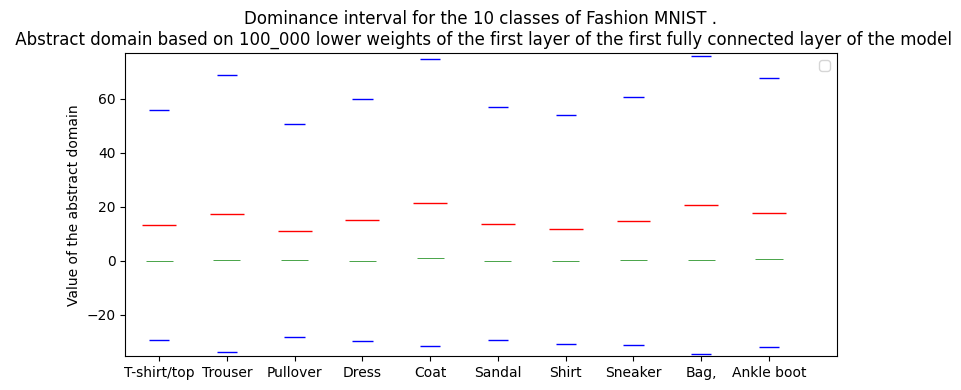

  8%|▊         | 39/500 [20:29<4:06:21, 32.06s/it]

Update parameter after EPOCH 9
Update parameter after EPOCH 9


/home/guillaume/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  8%|▊         | 40/500 [20:54<3:48:37, 29.82s/it]

EPOCH ACCURACY = 10.98 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


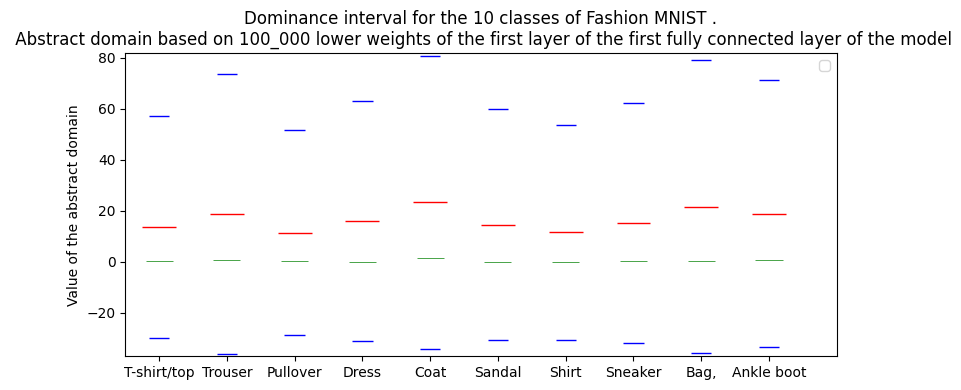

  9%|▉         | 45/500 [23:34<3:53:23, 30.78s/it]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


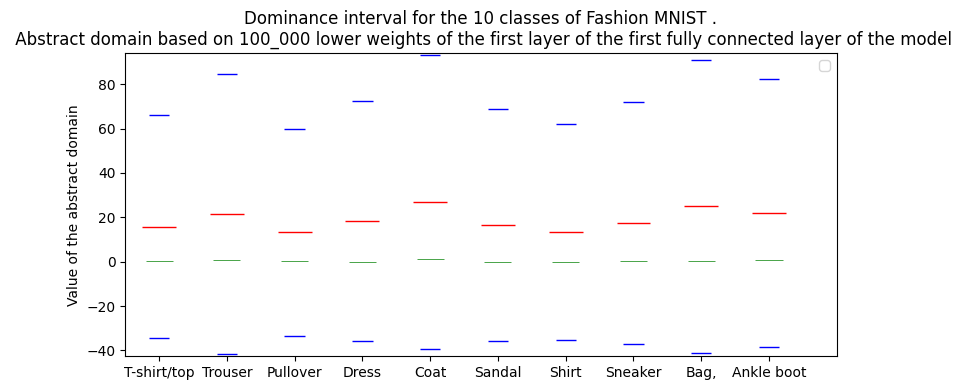

 10%|▉         | 49/500 [25:42<4:06:08, 32.75s/it]

Update parameter after EPOCH 9
Update parameter after EPOCH 9


/home/guillaume/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
 10%|█         | 50/500 [26:22<4:23:13, 35.10s/it]

EPOCH ACCURACY = 10.76 %


 10%|█         | 50/500 [26:32<3:58:50, 31.85s/it]


KeyboardInterrupt: 

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from abstract import abstractTensor as AT
from common import make_indice_and_values_tupple,plot_dominance
abstract_network = True

xticklabels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag,","Ankle boot"]

img_list = []
img_relevance_list =[]
conv1_weight_relevance_list = []
conv1_bias_relevance_list = []
conv2_weight_relevance_list = []
conv2_bias_relevance_list = []

fc1_weight_relevance_list = []
fc1_bias_relevance_list = []
fc2_weight_relevance_list = []
fc2_bias_relevance_list  = []
result_list =[]
num_label_list = []
name_label_list = []
true_predict_list = []




for i in tqdm(range(500)):
 
   
    scale = 0.1
    if abstract_network : 
    
        conv1_eps_weight = torch.tensor([])
        conv1__weight_span = torch.max(model.conv1.weight.data.flatten())-torch.min(model.conv1.weight.data.flatten())
        conv1_eps_weight.indices = torch.arange(0,len(model.conv1.weight.data.flatten()),1)
        conv1_eps_weight.values = scale*model.conv1.weight.data.flatten()
        conv1_eps_bias = torch.tensor([])
        conv1__bias_span = torch.max(model.conv1.bias.data.flatten())-torch.min(model.conv1.bias.data.flatten())
        conv1_eps_bias.indices = torch.arange(0,len(model.conv1.bias.data.flatten()),1)
        conv1_eps_bias.values = scale*torch.ones_like(model.conv1.bias.data.flatten())


        conv2_eps_weight = torch.tensor([])
        conv2_eps_weight.indices = torch.arange(0,len(model.conv2.weight.data.flatten()),1)
        conv2_weight_span = torch.max(model.conv2.weight.data.flatten())-torch.min(model.conv2.weight.data.flatten())
        conv2_eps_weight.values = scale*model.conv2.weight.data.flatten()
        conv2_eps_bias = torch.tensor([])
        conv2_eps_bias.indices = torch.arange(0,len(model.conv2.bias.data.flatten()),1)
        conv2_bias_span = torch.max(model.conv2.bias.data.flatten())-torch.min(model.conv2.bias.data.flatten())
        conv2_eps_bias.values = scale*torch.ones_like(model.conv2.bias.data.flatten())

        fc1_eps_weight = torch.tensor([])
        fc1_weight_span = torch.max(model.fc1[1].weight.data.flatten())-torch.min(model.fc1[1].weight.data.flatten())
        fc1_eps_weight.indices = torch.arange(0,len(model.fc1[1].weight.data.flatten()),1)
        fc1_eps_weight.values = scale*model.fc1[1].weight.data.flatten()
        fc1_eps_bias = torch.tensor([])
        fc1_bias_span = torch.max(model.fc1[1].bias.data.flatten())-torch.min(model.fc1[1].bias.data.flatten())
        fc1_eps_bias.indices = torch.arange(0,len(model.fc1[1].bias.data.flatten()),1)
        fc1_eps_bias.values = scale*torch.ones_like(model.fc1[1].bias.data.flatten())


        fc2_eps_weight = torch.tensor([])
        fc2_weight_span = torch.max(model.fc2[1].weight.data.flatten())-torch.min(model.fc2[1].weight.data.flatten())
        fc2_eps_weight.indices = torch.arange(0,len(model.fc2[1].weight.data.flatten()),1)
        fc2_eps_weight.values = scale*model.fc2[1].weight.data.flatten()
        fc2_eps_bias = torch.tensor([])
        fc2_bias_span = torch.max(model.fc2[1].bias.data.flatten())-torch.min(model.fc2[1].bias.data.flatten())
        fc2_eps_bias.indices = torch.arange(0,len(model.fc2[1].bias.data.flatten()),1)
        fc2_eps_bias.values = scale*torch.ones_like(model.fc2[1].bias.data.flatten())


    else :
        conv1_eps_weight = make_indice_and_values_tupple()
        conv1_eps_bias = make_indice_and_values_tupple()
       

        conv2_eps_weight = make_indice_and_values_tupple()
        conv2_eps_bias = make_indice_and_values_tupple()
        fc1_eps_bias = make_indice_and_values_tupple()
        fc1_eps_weight = make_indice_and_values_tupple()
        fc2_eps_weight = make_indice_and_values_tupple()
        fc2_eps_bias = make_indice_and_values_tupple()




    label = None

  
    while label!= i%10: 
        index = np.random.randint(0,5000)
        
        img, label = dataset_train[index]

    name_label_list.append(xticklabels[label])
    num_label_list.append(label)
   
    img_list.append(img)
    
    x=AT(img,alpha =0.08*scale*torch.ones(28*28))
    x=x.abstract_tensor()
 

    
  
    with torch.no_grad():
      
        
        result,x_min,x_max,x_true,len_symb, len_symb_c2, len_symb_fc1=model.abstract_forward(x,
                                                                    conv1_eps_bias=conv1_eps_bias,
                                                                    conv1_eps_weight=conv1_eps_weight,
                                                                    conv2_eps_weight = conv2_eps_weight,
                                                                    conv2_eps_bias = conv2_eps_bias,

                                                                    fc1_eps_weight =fc1_eps_weight,
                                                                    fc1_eps_bias = fc1_eps_bias, 
                                                                    fc2_eps_weight = fc2_eps_weight,
                                                                    fc2_eps_bias = fc2_eps_bias,

                                                                    add_symbol=True)
        
    result_list.append([result,x_min,x_max,x_true,len_symb, len_symb_c2, len_symb_fc1])    
    true_predict_list.append(torch.argmax(x_true))
    if i%5==0:
        plot_dominance(result,x_min,x_max,x_true)
    


    concatenated_heatmap_tensors =[]
    for j in range(10):
        concat_part =result[1:785,j]
        concatenated_heatmap_tensors.append(concat_part)
    concatenated_heatmap_tensors = torch.stack(concatenated_heatmap_tensors)

    img_relevance_list.append(concatenated_heatmap_tensors)

  
    if abstract_network:

        conv1_weight_concatenated_tensors = []
        conv1_bias_concatenated_tensors =[]
        for j in range(10):
            concat_part = result[len(x)-1:len(x)+143, j].view(16, 1, 3, 3)
            conv1_weight_concatenated_tensors.append(concat_part)
        conv1_weight_concatenated_tensors =torch.stack(conv1_weight_concatenated_tensors)
        for j in range(10):
            concat_part= result[len(x)+143:len(x)+159, j]
            conv1_bias_concatenated_tensors .append(concat_part)
        conv1_bias_concatenated_tensors = torch.stack(conv1_bias_concatenated_tensors )

        conv2_weight_concatenated_tensors = []
        conv2_bias_concatenated_tensors =[]
        for j in range(10):
            concat_part = result[len_symb-1:len_symb+4607, j].view(32, 16, 3, 3)
            conv2_weight_concatenated_tensors.append(concat_part)
        conv2_weight_concatenated_tensors =torch.stack(conv2_weight_concatenated_tensors)
        for j in range(10):
            concat_part = result[len_symb+4607:len_symb+4639, j]
            conv2_bias_concatenated_tensors.append(concat_part)
        conv2_bias_concatenated_tensors = torch.stack(conv2_bias_concatenated_tensors)

        fc1_weight_concatenated_tensors = []
        fc1_bias_concatenated_tensors =[]
        for j in range(10):
            concat_part = result[len_symb_c2-1:len_symb_c2+294911, j].reshape(64,4608)
            fc1_weight_concatenated_tensors.append(concat_part)
        fc1_weight_concatenated_tensors =torch.stack(fc1_weight_concatenated_tensors)
        for j in range(10):
            concat_part = result[len_symb_c2+294911:len_symb_c2+294975, j]
            fc1_bias_concatenated_tensors.append(concat_part)
        fc1_bias_concatenated_tensors= torch.stack(fc1_bias_concatenated_tensors)

        fc2_weight_concatenated_tensors = []
        fc2_bias_concatenated_tensors =[]
        for j in range(10):
            concat_part = result[len_symb_fc1-1:len_symb_fc1+639, j].view(10,64)
            fc2_weight_concatenated_tensors.append(concat_part)
        fc2_weight_concatenated_tensors =torch.stack(fc2_weight_concatenated_tensors)
        for j in range(10):
            concat_part = result[len_symb_fc1+639:len_symb_fc1+649, j]
            fc2_bias_concatenated_tensors.append(concat_part)
        fc2_bias_concatenated_tensors= torch.stack(fc2_bias_concatenated_tensors)

    


    conv1_weight_relevance_list.append(conv1_weight_concatenated_tensors)
    conv1_bias_relevance_list.append(conv1_bias_concatenated_tensors)
    conv2_weight_relevance_list.append(conv2_weight_concatenated_tensors)

    conv2_bias_relevance_list.append(conv2_bias_concatenated_tensors)

    fc1_weight_relevance_list.append(fc1_weight_concatenated_tensors)
    fc1_bias_relevance_list.append(fc1_bias_concatenated_tensors)
    fc2_weight_relevance_list.append(fc2_weight_concatenated_tensors)
    fc2_bias_relevance_list.append(fc2_bias_concatenated_tensors)

  
    k_min = 0
    k_plus = 1

  
    if ((i+1)%10)==0 :
        print(f"Update parameter after EPOCH {i%10}")
        for k in range (10):
            model.conv1.weight.data =model.conv1.weight.data+k_plus*(conv1_weight_relevance_list[-10+k][k]-k_min*(torch.sum(conv1_weight_relevance_list[-10+k][:k],dim =0)+torch.sum(conv1_weight_relevance_list[-10+k][k+1:],dim =0)))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
            model.conv1.bias.data = model.conv1.bias.data + k_plus*(conv1_bias_relevance_list[-10+k][k]-k_min*(torch.sum(conv1_bias_relevance_list[-10+k][:k],dim = 0)+torch.sum(conv1_bias_relevance_list[-10+k][k+1:],dim = 0)))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))

            model.conv2.weight.data =model.conv2.weight.data+k_plus*(conv2_weight_relevance_list[-10+k][k]-k_min*(torch.sum(conv2_weight_relevance_list[-10+k][:k],dim =0)+torch.sum(conv2_weight_relevance_list[-10+k][k+1:],dim =0)))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
            model.conv2.bias.data = model.conv2.bias.data + k_plus*(conv2_bias_relevance_list[-10+k][k]-k_min*(torch.sum(conv2_bias_relevance_list[-10+k][:k],dim = 0)+torch.sum(conv2_bias_relevance_list[-10+k][k+1:],dim = 0)))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))

            model.fc1[1].weight.data =model.fc1[1].weight.data+k_plus*(fc1_weight_relevance_list[-10+k][k]-k_min*(torch.sum(fc1_weight_relevance_list[-10+k][:k],dim =0)+torch.sum(fc1_weight_relevance_list[-10+k][k+1:],dim =0)))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
            model.fc1[1].bias.data = model.fc1[1].bias.data + k_plus*(fc1_bias_relevance_list[-10+k][k]-k_min*(torch.sum(fc1_bias_relevance_list[-10+k][:k],dim = 0)+torch.sum(fc1_bias_relevance_list[-10+k][k+1:],dim = 0)))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))

            model.fc2[1].weight.data =model.fc2[1].weight.data+k_plus*(fc2_weight_relevance_list[-10+k][k]-k_min*(torch.sum(fc2_weight_relevance_list[-10+k][:k],dim =0)+torch.sum(fc2_weight_relevance_list[-10+k][k+1:],dim =0)))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
            model.fc2[1].bias.data = model.fc2[1].bias.data + k_plus*(fc2_bias_relevance_list[-10+k][k]-k_min*(torch.sum(fc2_bias_relevance_list[-10+k][:k],dim = 0)+torch.sum(fc2_bias_relevance_list[-10+k][k+1:],dim = 0)))#/torch.no
    
        from custom_train import CustomTrainer as CT
        print(f"Update parameter after EPOCH {i%10}")
        eval =CT(model, device = device)
        eval.evaluate_model(dataset_test)

    

In [86]:
k_min = 0
k_plus = 100000000
for j in range(10):

    for k in range (10):
                model.conv1.weight.data =model.conv1.weight.data+k_plus*(conv1_weight_relevance_list[-10+k][k]-k_min*(torch.sum(conv1_weight_relevance_list[-10+k][:k],dim =0)+torch.sum(conv1_weight_relevance_list[-10+k][k+1:],dim =0)))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
                model.conv1.bias.data = model.conv1.bias.data + k_plus*(conv1_bias_relevance_list[-10+k][k]-k_min*(torch.sum(conv1_bias_relevance_list[-10+k][:k],dim = 0)+torch.sum(conv1_bias_relevance_list[-10+k][k+1:],dim = 0)))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))

                model.conv2.weight.data =model.conv2.weight.data+k_plus*(conv2_weight_relevance_list[-10+k][k]-k_min*(torch.sum(conv2_weight_relevance_list[-10+k][:k],dim =0)+torch.sum(conv2_weight_relevance_list[-10+k][k+1:],dim =0)))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
                model.conv2.bias.data = model.conv2.bias.data + k_plus*(conv2_bias_relevance_list[-10+k][k]-k_min*(torch.sum(conv2_bias_relevance_list[-10+k][:k],dim = 0)+torch.sum(conv2_bias_relevance_list[-10+k][k+1:],dim = 0)))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))

                model.fc1[1].weight.data =model.fc1[1].weight.data+k_plus*(fc1_weight_relevance_list[-10+k][k]-k_min*(torch.sum(fc1_weight_relevance_list[-10+k][:k],dim =0)+torch.sum(fc1_weight_relevance_list[-10+k][k+1:],dim =0)))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
                model.fc1[1].bias.data = model.fc1[1].bias.data + k_plus*(fc1_bias_relevance_list[-10+k][k]-k_min*(torch.sum(fc1_bias_relevance_list[-10+k][:k],dim = 0)+torch.sum(fc1_bias_relevance_list[-10+k][k+1:],dim = 0)))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))

                model.fc2[1].weight.data =model.fc2[1].weight.data+k_plus*(fc2_weight_relevance_list[-10+k][k]-k_min*(torch.sum(fc2_weight_relevance_list[-10+k][:k],dim =0)+torch.sum(fc2_weight_relevance_list[-10+k][k+1:],dim =0)))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
                model.fc2[1].bias.data = model.fc2[1].bias.data + k_plus*(fc2_bias_relevance_list[-10+k][k]-k_min*(torch.sum(fc2_bias_relevance_list[-10+k][:k],dim = 0)+torch.sum(fc2_bias_relevance_list[-10+k][k+1:],dim = 0)))#/torch.no
                print(torch.sum(conv1_weight_relevance_list[-10+k][k]))
    from custom_train import CustomTrainer as CT
    print(f"Update parameter after EPOCH {i%10}")
    eval =CT(model, device = device)
    eval.evaluate_model(dataset_test)


tensor(-0.0039)
tensor(-0.0066)
tensor(0.0065)
tensor(0.0094)
tensor(-0.0230)
tensor(0.0033)
tensor(-0.0124)
tensor(-0.0085)
tensor(0.0192)
tensor(-0.0131)
Update parameter after EPOCH 9
EPOCH ACCURACY = 10.00 %
tensor(-0.0039)
tensor(-0.0066)
tensor(0.0065)
tensor(0.0094)
tensor(-0.0230)
tensor(0.0033)
tensor(-0.0124)
tensor(-0.0085)
tensor(0.0192)
tensor(-0.0131)
Update parameter after EPOCH 9
EPOCH ACCURACY = 10.00 %
tensor(-0.0039)
tensor(-0.0066)
tensor(0.0065)
tensor(0.0094)
tensor(-0.0230)
tensor(0.0033)
tensor(-0.0124)
tensor(-0.0085)
tensor(0.0192)
tensor(-0.0131)
Update parameter after EPOCH 9
EPOCH ACCURACY = 10.00 %
tensor(-0.0039)
tensor(-0.0066)
tensor(0.0065)
tensor(0.0094)
tensor(-0.0230)
tensor(0.0033)
tensor(-0.0124)
tensor(-0.0085)
tensor(0.0192)
tensor(-0.0131)
Update parameter after EPOCH 9


KeyboardInterrupt: 

In [88]:
print(torch.min(model.conv2.weight.data))

tensor(-1531542.5000)
